I will start off by performing data processing to analyze Olist's Brazilian ecommerce reviews and data. I will implement this by importing the required Python libraries and mounting my Google Drive to read my data files. These datasets include: customer review (1-5), customer info, order details, payment details, and seller info.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu, ttest_ind
from google.colab import drive

from os.path import join

%matplotlib inline

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# prefix used for file I/O
path_prefix = "/content/drive/My Drive/DSA210/Project/Brazil_ecommerce_dataset/"

# Define dtype specifications on import for problematic columns with mixed types
dtype_spec = {
    'product_name_lenght': 'float64',
    'product_description_lenght': 'float64',
    'product_photos_qty': 'float64',
    'product_weight_g': 'float64',
    'product_length_cm': 'float64',
    'product_height_cm': 'float64',
    'product_width_cm': 'float64',
    'customer_zip_code_prefix': 'int64',
    'seller_zip_code_prefix': 'int64'
}

# Read all data files
products_df = pd.read_csv(join(path_prefix, "olist_products_dataset.csv"))
sellers_df = pd.read_csv(join(path_prefix, "olist_sellers_dataset.csv"))
categoryName_df = pd.read_csv(join(path_prefix, "product_category_name_translation.csv"))
orderItems_df = pd.read_csv(join(path_prefix, "olist_order_items_dataset.csv"))
payments_df = pd.read_csv(join(path_prefix, "olist_order_payments_dataset.csv"))
reviews_df = pd.read_csv(join(path_prefix, "olist_order_reviews_dataset.csv"))
orders_df = pd.read_csv(join(path_prefix, "olist_orders_dataset.csv"))
customers_df = pd.read_csv(join(path_prefix, "olist_customers_dataset.csv"))
geolocation_df = pd.read_csv(join(path_prefix, "olist_geolocation_dataset.csv"))

# --- Merging Process ---
#processing geographic data
# Aggregate geo data by zip code prefix (first entry for each)
geo_agg = geolocation_df.groupby('geolocation_zip_code_prefix').first().reset_index()

# 1. Merge product category translations
products_merged = pd.merge(
    products_df,
    categoryName_df,
    on='product_category_name',
    how='inner'
).drop(columns=['product_category_name']).rename(
    columns={'product_category_name_english': 'product_category'}
)
# 2. Merge products and sellers with order items
order_items_merged = pd.merge(
    orderItems_df,
    products_merged,
    on='product_id',
    how='inner'
)
order_items_merged = pd.merge(
    order_items_merged,
    sellers_df,
    on='seller_id',
    how='inner'
)
# 3. Merge all order information
orders_merged = pd.merge(
    orders_df,
    order_items_merged,
    on='order_id',
    how='inner'
)
orders_merged = pd.merge(
    orders_merged,
    payments_df,
    on='order_id',
    how='inner'
)
orders_merged = pd.merge(
    orders_merged,
    reviews_df,
    on='order_id',
    how='inner'
)
# 4. Merge with customer data
data = pd.merge(
    orders_merged,
    customers_df,
    on='customer_id',
    how='inner'
)
# 5. Merge geographic data for customers
data = pd.merge(
    data,
    geo_agg,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner',
    suffixes=('', '_customer')
)
# 6. Merge geographic data for sellers
data = pd.merge(
    data,
    geo_agg,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner',
    suffixes=('', '_seller')
)
# change column names for readability
data = data.rename(columns={
    'geolocation_lat': 'customer_latitude',
    'geolocation_lng': 'customer_longitude',
    'geolocation_lat_seller': 'seller_latitude',
    'geolocation_lng_seller': 'seller_longitude'
})

Mounted at /content/drive


<ipython-input-43-95b2cc4a0e8a>:42: DtypeWarning: Columns (15,19,20,21,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.read_csv(join(path_prefix, "olist_orders_dataset.csv"))


#Studying My Dataset

 In order to decide the next step, I will verify the merginng and investigate my dataset by showing:
   

*   The **shape** of the dataframe
*   The **type** of each **column**

*   The **head** of the data


*   The **dicriptive statistics** for teh numerical data




In [44]:
print(f"\nMerged DataFrame: {data.shape}")
print("\nMerged DataFrame head:")
print(data.head())


Merged DataFrame: (115037, 90)

Merged DataFrame head:
                           order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered           9/13/2017 8:59    9/13/2017 9:45   
1    delivered          4/26/2017 10:53   4/26/2017 11:05   
2    delivered          1/14/2018 14:33   1/14/2018 14:48   
3    delivered           8/8/2018 10:00    8/8/2018 10:10   
4    delivered           2/4/2017 13:57    2/4/2017 14:10   

  order_delivered_carrier_date order_delivered_customer_date  \
0              9/19/2017 18:34               9/20/2017 23:43   
1         

In [45]:
print("\nColumn datatypes:")
print(data.dtypes)


Column datatypes:
order_id                     object
customer_id                  object
order_status                 object
order_purchase_timestamp     object
order_approved_at            object
                             ...   
seller_longitude            float64
geolocation_city_seller      object
geolocation_state_seller     object
Unnamed: 5_seller           float64
Unnamed: 6_seller           float64
Length: 90, dtype: object


In [46]:
print("\nDescriptive statistics for numerical columns:")
print(data.describe())


Descriptive statistics for numerical columns:
       Unnamed: 8_x  Unnamed: 9  Unnamed: 10_x  Unnamed: 11_x  Unnamed: 12_x  \
count           0.0         0.0            0.0            0.0            0.0   
mean            NaN         NaN            NaN            NaN            NaN   
std             NaN         NaN            NaN            NaN            NaN   
min             NaN         NaN            NaN            NaN            NaN   
25%             NaN         NaN            NaN            NaN            NaN   
50%             NaN         NaN            NaN            NaN            NaN   
75%             NaN         NaN            NaN            NaN            NaN   
max             NaN         NaN            NaN            NaN            NaN   

       Unnamed: 13_x  Unnamed: 14_x  Unnamed: 16_x  Unnamed: 17  Unnamed: 18  \
count            0.0     247.000000     247.000000   247.000000   247.000000   
mean             NaN       1.032389       2.813765   159.553684     1.13

# Data Processing

# Date Columns Conversion, Creating New Time Feature Columns, and Sorting


*  By observing the previous code block, I will **convert** the data type of the following columns from object **to dateime:** estimated delivery time, actual delivery time, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date.

-

* Creating meaningful data by calculating **new columns**: **actual delivery duration** and **delivery delay** by subtracting the values in estimated delivery time column from the actual delivery time column.

-


* **Sort** Data with respect to the **order_purchase_timestamp** column, to get orders in chronological sequence , which is the most useful view for e-commerce analysis, such as: Time series analysis, understanding sales trends, and maintaining transaction chronology



In [47]:
# Data Cleaning
# Convert all date columns to datetime objects
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
]
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Verify datetime conversion
print("\nDate columns after conversion:")
print(data.dtypes)

# Calculate time-based features
data['purchase_to_delivery_days'] = (
    (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
)
data['delivery_delay_days'] = (
    (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days
)
data['review_response_time_days'] = (
    (data['review_answer_timestamp'] - data['review_creation_date']).dt.days
)

#Sort by order purchase timestamp
final_data = data.sort_values('order_purchase_timestamp', ascending=True)

# Display conversion and sorted data to verify sorting
print(f"\nDate range: {data['order_purchase_timestamp'].min()} to {data['order_purchase_timestamp'].max()}")
print(f"Data shape: {data.shape}")
data.head()


Date columns after conversion:
order_id                            object
customer_id                         object
order_status                        object
order_purchase_timestamp    datetime64[ns]
order_approved_at           datetime64[ns]
                                 ...      
seller_longitude                   float64
geolocation_city_seller             object
geolocation_state_seller            object
Unnamed: 5_seller                  float64
Unnamed: 6_seller                  float64
Length: 90, dtype: object

Date range: 2016-09-04 21:15:00 to 2018-09-03 09:06:00
Data shape: (115037, 93)


order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-09-13 08:59:00 2017-09-13 09:45:00   
1    delivered      2017-04-26 10:53:00 2017-04-26 11:05:00   
2    delivered      2018-01-14 14:33:00 2018-01-14 14:48:00   
3    delivered      2018-08-08 10:00:00 2018-08-08 10:10:00   
4    delivered      2017-02-04 13:57:00 2017-02-04 14:10:00   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-09-19 18:34:00           2017-09-20 23:43:00   
1          2017-05-04 14:35:00           2017-05-12 16:04:00   
2          2018-01-16 12:36:00           2018-01-22 13:19:00   
3          2018-08-10 13:28:00           2018-08-14 13:32:00   
4          2017-02-16 09:46:00           2017-03-01 16:42:00   

  order_estimated_delivery_date  Unnamed: 8_x  Unnamed: 9  ...  \
0                    2017-09-29           NaN         NaN  ...   
1                    2017-05-15           NaN         NaN  ...   
2                    2018-02-05           NaN         NaN  ...   
3                    2018-08-20           NaN         NaN  ...   
4                    2017-03-17           NaN         NaN  ...   

   geolocation_zip_code_prefix_seller  seller_latitude  seller_longitude  \
0                               27277       -22.498183        -44.123614   
1                                3471       -23.566258        -46.518417   
2                               37564       -22.264094        -46.158564   
3                               14403       -20.548228        -47.395897   
4                               87900       -22.931427        -53.133759   

   geolocation_city_seller  geolocation_state_seller Unnamed: 5_seller  \
0            volta redonda                        RJ               NaN   
1                sao paulo                        SP               NaN   
2            borda da mata                        MG               NaN   
3                   franca                        SP               NaN   
4                   loanda                        PR               NaN   

   Unnamed: 6_seller  purchase_to_delivery_days  delivery_delay_days  \
0                NaN                        7.0                 -9.0   
1                NaN                       16.0                 -3.0   
2                NaN                        7.0                -14.0   
3                NaN                        6.0                 -6.0   
4                NaN                       25.0                -16.0   

  review_response_time_days  
0                         1  
1                         2  
2                         0  
3                         0  
4                         1  

[5 rows x 93 columns]

# Missing Values (NaN Values)


I will Check the NaN values and print the percentages per column to identify which columns have missing values.


In [48]:
#Data Cleaning
#check for NaN values and calculate percentages
nan_percentage = data.isnull().sum() / len(data) * 100

# Print columns with NaN values and their percentages
print("\nPercentage of NaN values per column:")
print(nan_percentage[nan_percentage > 0])


Percentage of NaN values per column:
order_approved_at                  0.012170
order_delivered_carrier_date       1.030103
order_delivered_customer_date      2.072377
Unnamed: 8_x                     100.000000
Unnamed: 9                       100.000000
Unnamed: 10_x                    100.000000
Unnamed: 11_x                    100.000000
Unnamed: 12_x                    100.000000
Unnamed: 13_x                    100.000000
Unnamed: 14_x                     99.785286
Unnamed: 15_x                     99.785286
Unnamed: 16_x                     99.785286
Unnamed: 17                       99.785286
Unnamed: 18                       99.785286
Unnamed: 19                       99.785286
Unnamed: 20                       99.785286
Unnamed: 21                       99.785286
Unnamed: 22                       99.785286
Unnamed: 23                       99.785286
Unnamed: 24                       99.785286
Unnamed: 25                       99.785286
Unnamed: 26                       99.7

# Dealing with the NaN
Since there are several unnamed columns with very high NaN percetage (100%), I will drop those columns with a threshold of 50% NaN.

In [49]:
# Identify columns with a high percentage of NaN values with a threshold of 70%
high_nan_columns = nan_percentage[nan_percentage > 50].index
print(f"\nColumns identified for potential dropping due to >50% NaN values: {list(high_nan_columns)}")

# Drop the identified columns from the DataFrame and then display the shape of the dataset
data = data.drop(columns=high_nan_columns)
print(f"\nDataFrame shape after dropping high NaN columns: {data.shape}")

# Verify missing values in the new DataFrame
missing_percent_after_dropping_cols = (data.isnull().sum() / len(data)) * 100

print("\nMissing values after dropping high NaN percentage columns:")
# Only print columns that still have missing values
cols_with_nan_after_col_drop = missing_percent_after_dropping_cols[missing_percent_after_dropping_cols > 0].index
if len(cols_with_nan_after_col_drop) > 0:
    for col in cols_with_nan_after_col_drop:
        print(f"{col}: ({missing_percent_after_dropping_cols[col]:.5f}%)")
else:
    print("No missing values remaining in the selected columns.")



Columns identified for potential dropping due to >50% NaN values: ['Unnamed: 8_x', 'Unnamed: 9', 'Unnamed: 10_x', 'Unnamed: 11_x', 'Unnamed: 12_x', 'Unnamed: 13_x', 'Unnamed: 14_x', 'Unnamed: 15_x', 'Unnamed: 16_x', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 7_x', 'Unnamed: 8_y', 'Unnamed: 9_x', 'Unnamed: 10_y', 'Unnamed: 11_y', 'Unnamed: 12_y', 'Unnamed: 13_y', 'Unnamed: 14_y', 'Unnamed: 15_y', 'Unnamed: 16_y', 'Unnamed: 9_y', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'review_comment_title', 'review_comment_message', 'Unnamed: 7_y', 'Unnamed: 1', 'Unnamed: 6', 'Unnamed: 5', 'Unnamed: 6_customer', 'Unnamed: 5_seller', 'Unnamed: 6_seller']

DataFrame shape after dropping high NaN columns: (115037, 50)

Missing values after dropping high NaN percentage columns:
order_approved_at: (0.01217%)
order_delivered_carrier_date: (1.03010%)
order_delivered_customer_d

In [50]:
# used AI, prompt: fix the error ipython-input-7-e6158c683f32>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
# The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

# Identify columns that still have missing values
cols_with_nan = data.columns[data.isnull().any()].tolist()

print(f"\nColumns with remaining NaN values: {cols_with_nan}")

for col in cols_with_nan:
    if data[col].dtype in ['float64', 'int64']:
        # For numerical columns, fill NaN with the mean
        data[col] = data[col].fillna(data[col].mean())
    elif data[col].dtype == 'object':
        # For object/categorical columns, fill NaN with the mode
        # Check if mode exists before filling
        if not data[col].mode().empty:
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            print(f"Column '{col}' is object type with NaN values and no mode. Consider dropping or another filling strategy.")
    elif data[col].dtype == 'datetime64[ns]':
        # for datetime columns I will use forward fill
        data[col] = data[col].ffill()
    else:
        # Handle other potential data types if necessary
        print(f"Column '{col}' has an unhandled dtype '{data[col].dtype}' with NaN values.")

# Final check for missing values
missing_percent_final = (data.isnull().sum() / len(data)) * 100
print("\nFinal check for missing values:")
cols_with_nan_final = missing_percent_final[missing_percent_final > 0].index

if len(cols_with_nan_final) > 0:
    for col in cols_with_nan_final:
        print(f"{col}: ({missing_percent_final[col]:.2f}%)")
else:
    print("No missing values remaining in the DataFrame.")

print(f"\nFinal DataFrame shape after dealing with remaining NaNs: {data.shape}")



Columns with remaining NaN values: ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'purchase_to_delivery_days', 'delivery_delay_days']

Final check for missing values:
No missing values remaining in the DataFrame.

Final DataFrame shape after dealing with remaining NaNs: (115037, 50)


Saving the clean, merged and processed data into an excel sheet

In [51]:
output_excel = join(path_prefix, "brazilian_ecommerce_merged.xlsx")
print(f"Saving cleaned and merged data to Excel file: {output_excel}")
with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    data.to_excel(writer, index=False, sheet_name='Merged Data')

print(data.head(2))

Saving cleaned and merged data to Excel file: /content/drive/My Drive/DSA210/Project/Brazil_ecommerce_dataset/brazilian_ecommerce_merged.xlsx
                           order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-09-13 08:59:00 2017-09-13 09:45:00   
1    delivered      2017-04-26 10:53:00 2017-04-26 11:05:00   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-09-19 18:34:00           2017-09-20 23:43:00   
1          2017-05-04 14:35:00           2017-05-12 16:04:00   

  order_estimated_delivery_date  order_item_id  \
0                    2017-09-29              1   
1                    2017-05-15              1   

                         product_id  ...       geolocation_city  \
0  4244733e06e7ecb4970a6e2683c13e61  

# Visualization

<ipython-input-52-3e736c37610b>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = data.set_index('order_purchase_timestamp').resample('M')['order_id'].nunique()


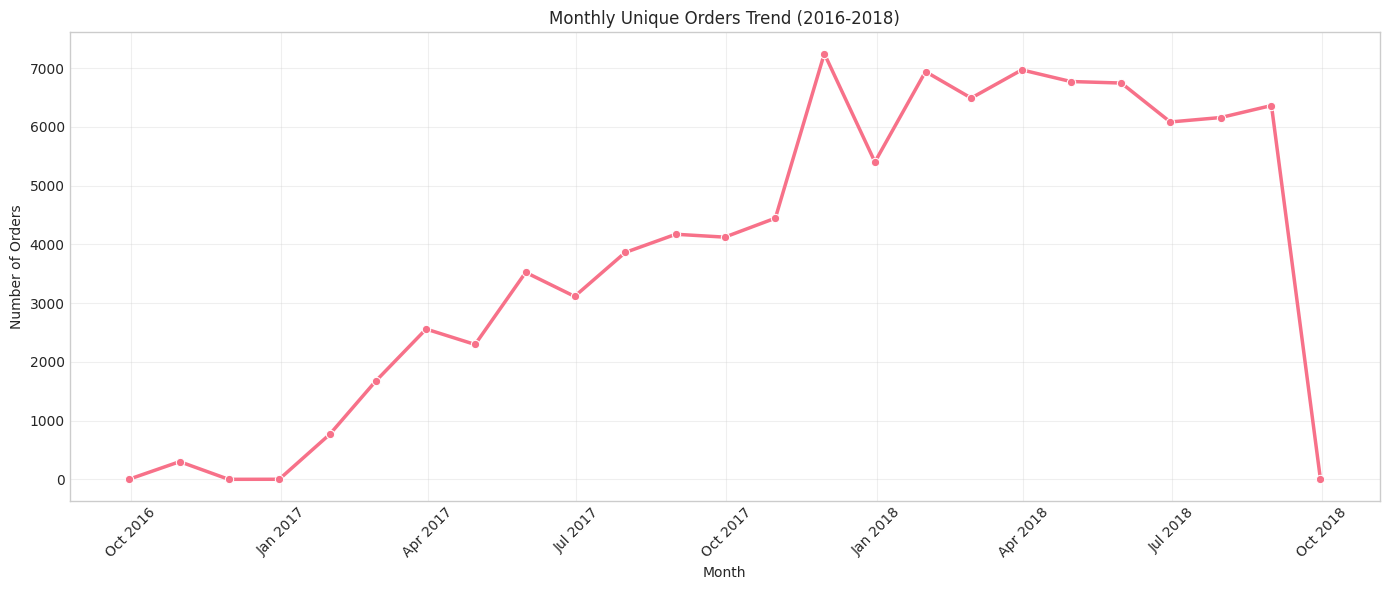

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Set visual style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 1. SALES TREND ANALYSIS (YEAR-MONTH)
plt.figure(figsize=(14, 6))
monthly_orders = data.set_index('order_purchase_timestamp').resample('M')['order_id'].nunique()
ax = sns.lineplot(data=monthly_orders, marker='o', linewidth=2.5)
ax.set(title='Monthly Unique Orders Trend (2016-2018)',
       ylabel='Number of Orders',
       xlabel='Month')
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This time series graph for the order purchase time per month and the number of unique orders shows a **growth trend in the order volume from 2016 to 2018,** this can be explained by the Brazilian Economy's reviving ecommerce after the 2016 economic recession and seasonal spikes later on. This exemplifies teh business life cycle of Olist.

However, there is a sudden sharp fall in the number of orders at the end of 2018. This suggests market maturation, competitive pressure, or perhaps incomplete data.

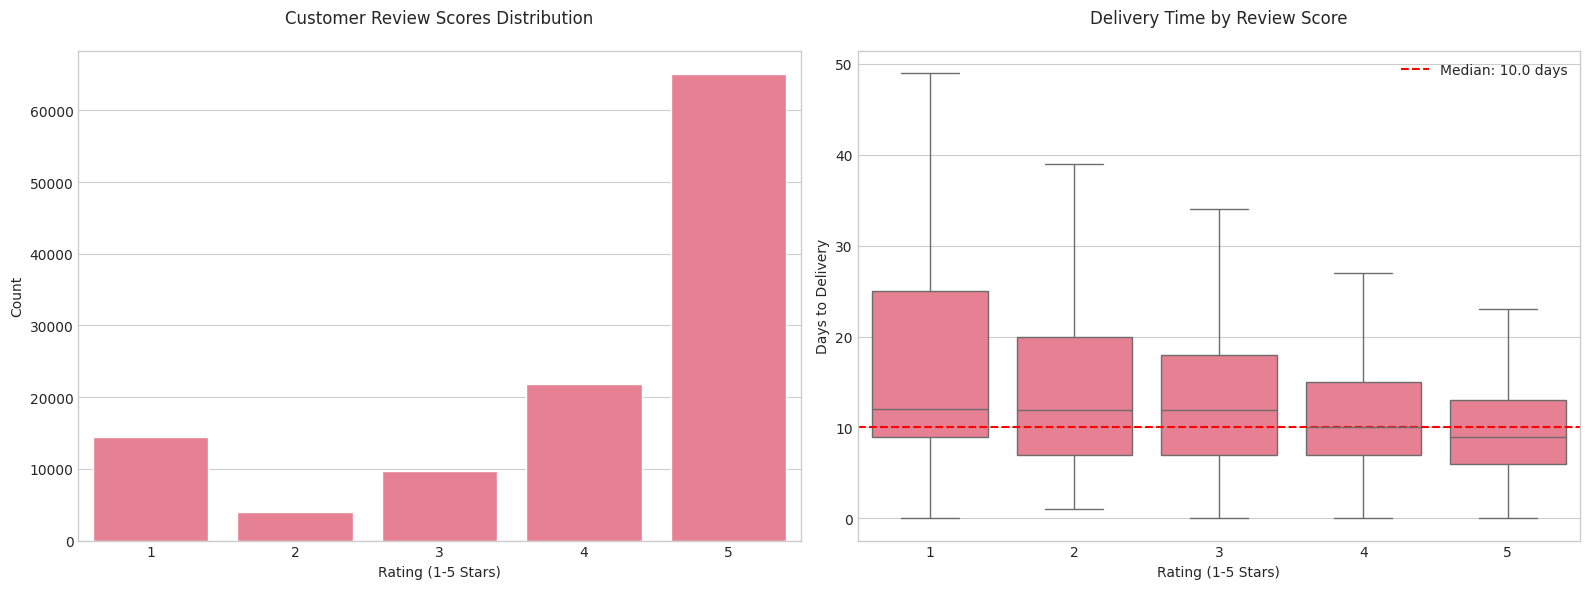

In [53]:
# 2. CUSTOMER SATISFACTION DASHBOARD
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Review Score Distribution
sns.countplot(data=data, x='review_score', ax=ax1,
              order=sorted(data['review_score'].dropna().unique()))
ax1.set_title('Customer Review Scores Distribution', pad=20)
ax1.set_xlabel('Rating (1-5 Stars)')
ax1.set_ylabel('Count')

# Review Score vs Delivery Time
sns.boxplot(data=data, x='review_score', y='purchase_to_delivery_days',
            ax=ax2, showfliers=False)
ax2.set_title('Delivery Time by Review Score', pad=20)
ax2.set_xlabel('Rating (1-5 Stars)')
ax2.set_ylabel('Days to Delivery')
ax2.axhline(y=data['purchase_to_delivery_days'].median(),
            color='red', linestyle='--',
            label=f'Median: {data["purchase_to_delivery_days"].median():.1f} days')
ax2.legend()

plt.tight_layout()
plt.show()

The bar graph on the left of the review scores (ranging from 1 to 5) with the count of the count of reviews for each score, shows the distribution of the cutomer reviews. It is clear that 5  was the most given seleted review score.


The box plot of the delivery time by the review score reveals **a strong negative correlation between delivery time and satisfaction of customers**.


 For instnace, the 1-star reviews experienced ~25 days delivery vs ~15 days for 5-star reviews. so can say that faster deliveries correlate to better customer satisfaction.


 The dashed line represents the overall median delivery time (~10 days) regardless of the review scores. I used this as a baseline to analyze whether certain raitings had faster or slower than average delivery.


 5 score reviews are below the line, indicating they had the fastest delivery time overall, which proves the previous correlation.


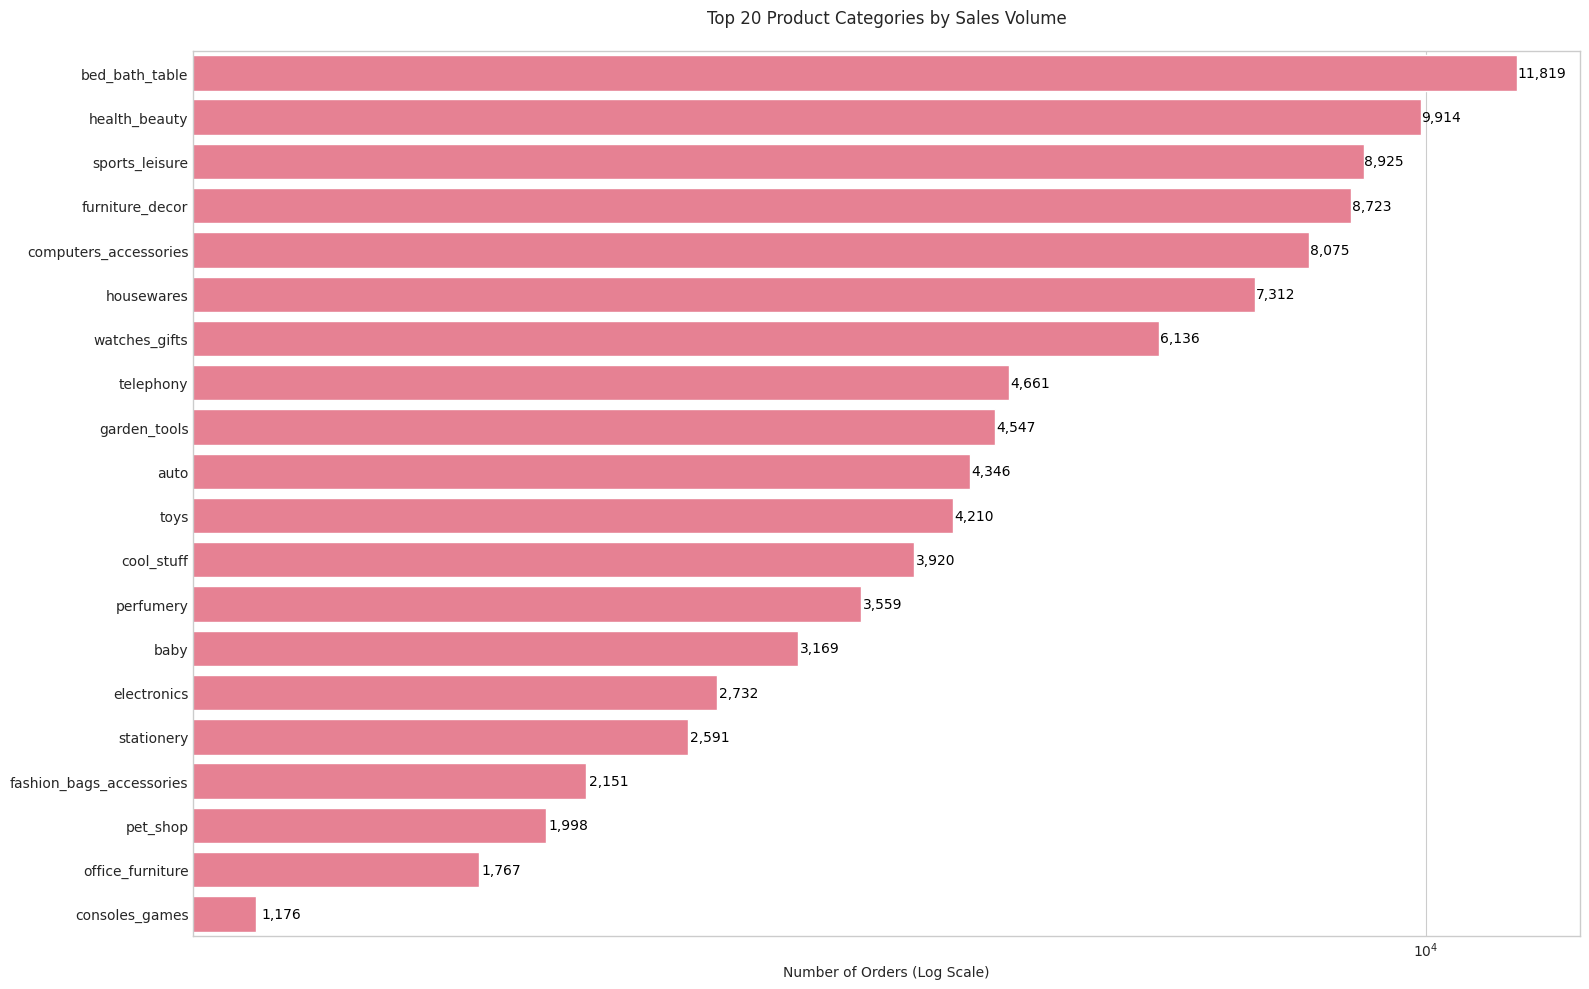

In [54]:
# 3. PRODUCT CATEGORY ANALYSIS
plt.figure(figsize=(16, 10))
top_cats = data['product_category'].value_counts().nlargest(20)
sns.barplot(y=top_cats.index, x=top_cats.values, orient='h')
plt.title('Top 20 Product Categories by Sales Volume', pad=20)
plt.xlabel('Number of Orders (Log Scale)')
plt.xscale('log')
plt.ylabel('')

# Add value labels
for i, v in enumerate(top_cats.values):
    plt.text(v+10, i, f"{v:,}", color='black', va='center')

plt.tight_layout()
plt.show()

I implemented a horizontal bar chart with logarithmic scale (to make the difference appear smaller than they are) for the number of orders and the product categories. The logarithmic scale reveals disporpotionately high sales concentration for bed/bath/table products leading at ~12,000 orders, followed by health/beauty (~10,000) and sports/leisure (~9,000). whereas, categories from electronics downward have much less sales volume. The domination of the home categories suggests that Olist serves practical household needs more than luxury or specialty items.


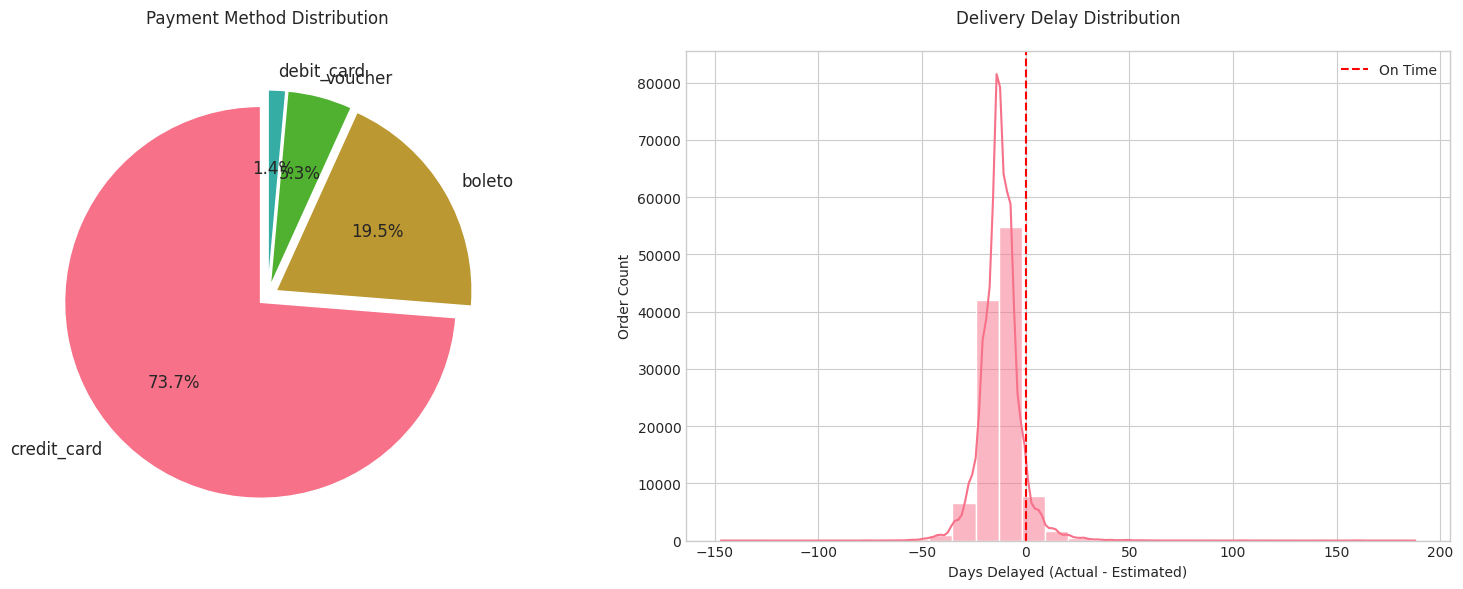

In [55]:
# 4. PAYMENT & DELIVERY ANALYSIS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Payment Methods
payment_data = data['payment_type'].value_counts()
ax1.pie(payment_data, labels=payment_data.index,
        autopct='%1.1f%%', startangle=90,
        explode=[0.05]*len(payment_data),
        textprops={'fontsize': 12})
ax1.set_title('Payment Method Distribution', pad=20)

# Delivery Performance
sns.histplot(data=data, x='delivery_delay_days', bins=30,
             kde=True, ax=ax2)
ax2.set_title('Delivery Delay Distribution', pad=20)
ax2.set_xlabel('Days Delayed (Actual - Estimated)')
ax2.set_ylabel('Order Count')
ax2.axvline(x=0, color='red', linestyle='--', label='On Time')
ax2.legend()

plt.tight_layout()
plt.show()

The left plot is a pie chart of the paymenty method percentages and order count. The chart shows an overwhelming **preference for credit cards (73.7%)** over alternative payments like boleto (19.5%).


The Histogram with normal distribution overlay on the right, grapahs the number of delayed delivery Days (esitmated - actual) with the order count. It reveals Olist's great logistics performance given the narrow normal distribution centered slightly left of zero, with the peak around -5 (early) to 0 days. **This highlisghts the relaibility of Olist's delivery, and as indicated by the center mean, most deliveries are early.**



The red dashed line at 0 days represents the "On Time" delivery benchmark. This serves as a critical reference point that divides the distribution into two meaningful zones: deliveries that arrived early (left of the line, negative values) and deliveries that were delayed (right of the line, positive values). hence, immediately we notice that majority of order deliveries (approximately 60-70%) are ealry or on time and the remaining are late just by looking at the histogram. This is useful for monitoring and assessing performance with customer satisfaction metrics.

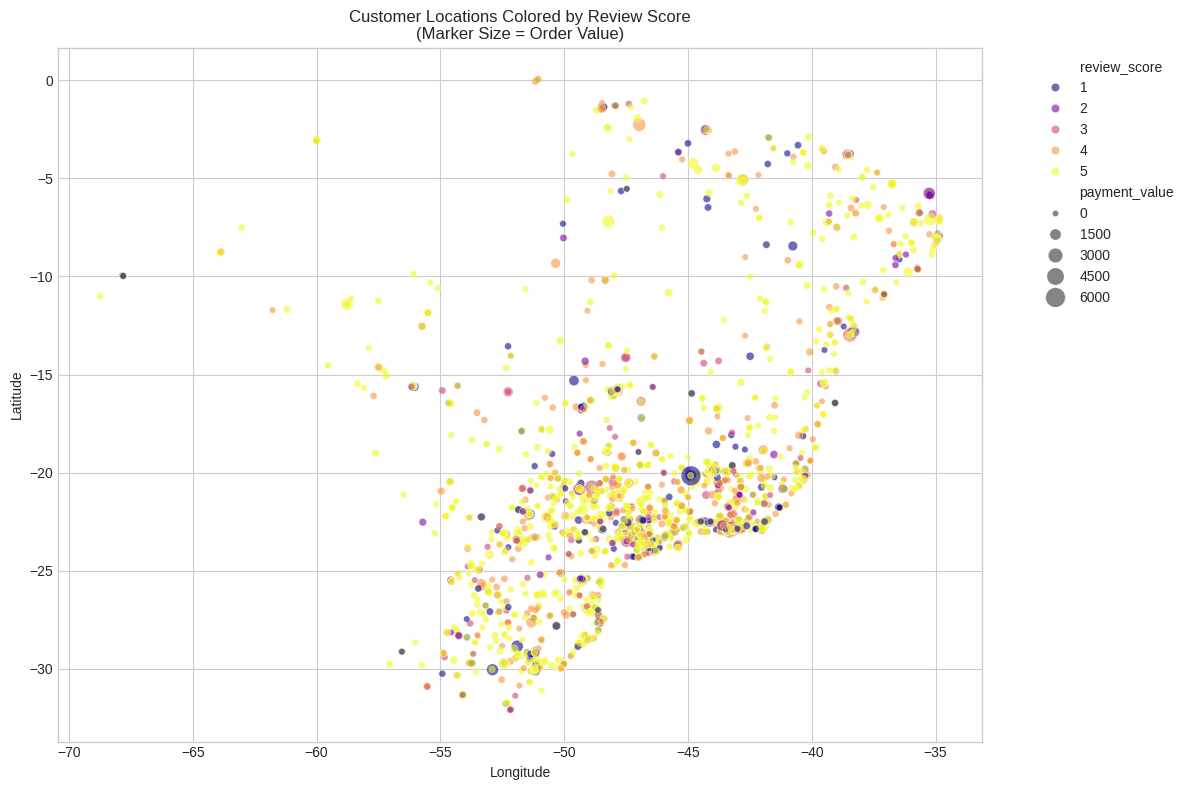

In [79]:
# 5. CUSTOMER GEOGRAPHY
if all(col in data.columns for col in ['customer_latitude', 'customer_longitude']):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data.sample(5000),  # Sample for performance
                    x='customer_longitude',
                    y='customer_latitude',
                    size='payment_value',
                    sizes=(20, 200),
                    alpha=0.6,
                    hue='review_score',
                    palette='plasma')
    plt.title('Customer Locations Colored by Review Score\n(Marker Size = Order Value)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



I plotted a Scatter plot with geographic coordinates (Longitude, Latitude) for customer with their Review score (1-5) color cordinated and Payment value as the size of dots. the geographic distrivbution reveals Olist customers are concentrated heavily in Brazil's Southeast region (São Paulo-Rio corridor around -23° latitude), with sparse coverage in northern and western regions.

the review scores are randomly distributed across geography without a distinct pattern, suggesting service quality consistency across locations. WHereas,the marker sizes reveals that higher-value orders are also concentrated in the Southeast megalopolis, reflecting regional economic disparities.


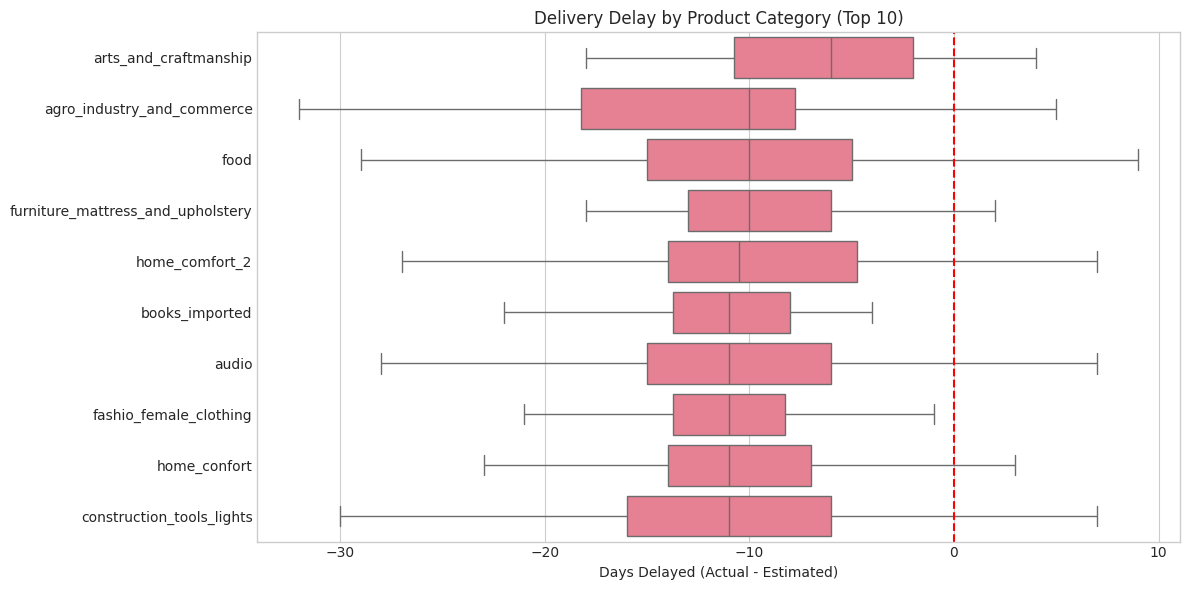

In [57]:
# 6. DELIVERY DELAY ANALYSIS
plt.figure(figsize=(12, 6))
sns.boxplot(data=data,
            y='product_category',
            x='delivery_delay_days',
            showfliers=False,
            order=data.groupby('product_category')['delivery_delay_days']
                          .median()
                          .sort_values(ascending=False)
                          .index[:10])
plt.title('Delivery Delay by Product Category (Top 10)')
plt.xlabel('Days Delayed (Actual - Estimated)')
plt.ylabel('')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

This box plot for the Days delayed (Actual - Estimated) and top 10 Product reveals tat the arts_and_craftmanship has the worst delivery performance (median ~12 days late with high variability), followed by agro_industry_and_commerce and food categories. These delays likely reflect supply chain complexity, with specialized or perishable items requiring different handling.

Conversely, categories like books_imported, fashio_female_clothing, and construction_tools show better performance, clustering around on-time delivery.

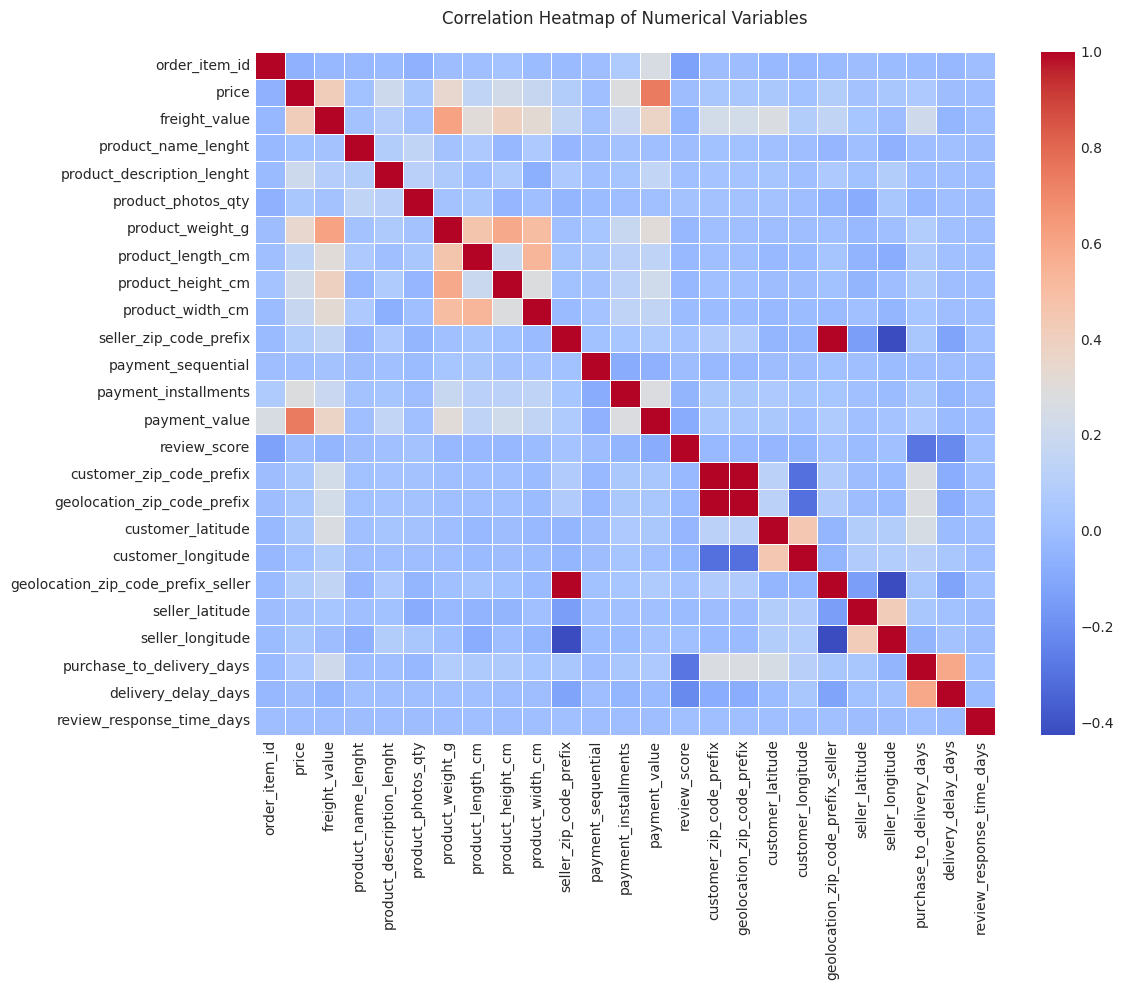

In [58]:
import matplotlib.pyplot as plt
# 7. CORRELATION HEATMAP
# i will choose the numerical columns for correlation analysis
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_data = data[numerical_cols]

# calculationd for the correlation matrix
corr_matrix = correlation_data.corr()

# Creating the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Variables', pad=20)
plt.tight_layout()
plt.show()

The Correlation Heatmap of Numerical Variables surprisingly reveals minimal correlation between price and most other variables, suggesting pricing isn't strongly tied to product size or delivery performance. The delivery delay and purchase-to-delivery days show moderate positive correlation (~0.6), indicating that longer overall delivery times often result in delays relative to estimates.



In [80]:
# AI prompt use: create a follium map  for customers seperately ans sellers seperately then combined with the customer and sellers longitude and lattitude columns to show the distance between them. make the markers smaller so the line are visible
import numpy as np
!pip install folium

import folium
from folium.plugins import MarkerCluster
from folium.utilities import parse_options
from collections import defaultdict

# Create a map centered around Brazil
m = folium.Map(location=[-14.235, -51.9253], zoom_start=4)

# Create feature groups for customers, sellers, and connections
customer_group = folium.FeatureGroup(name='Customers').add_to(m)
seller_group = folium.FeatureGroup(name='Sellers').add_to(m)
connection_group = folium.FeatureGroup(name='Customer-Seller Connections').add_to(m)

# ILL consider a sample of the data o avoid plotting every single point and line (can be millions),.
# Let's use unique order IDs for sampling.
sampled_orders = data['order_id'].unique().tolist()
sample_size = 1000
if len(sampled_orders) > sample_size:
    sampled_order_ids = np.random.choice(sampled_orders, size=sample_size, replace=False)
    sampled_data = data[data['order_id'].isin(sampled_order_ids)].copy()
else:
    sampled_data = data.copy()

# Use sets to keep track of added customers and sellers to avoid duplicates
added_customers = set()
added_sellers = set()

# Dictionary to store the count of connections between each customer-seller pair
connection_counts = defaultdict(int)

# Loop through the sampled data to add markers and lines
for index, row in sampled_data.iterrows():
    cust_lat = row['customer_latitude']
    cust_lng = row['customer_longitude']
    seller_lat = row['seller_latitude']
    seller_lng = row['seller_longitude']
    customer_unique_id = row['customer_unique_id'] # Using unique customer ID for key
    seller_id = row['seller_id']

    # Add customer marker only if not already added
    if customer_unique_id not in added_customers:
        folium.CircleMarker(
            location=[cust_lat, cust_lng],
            radius=3, # Smaller radius
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip=f"Customer ID: {customer_unique_id}<br>Review Score: {row['review_score']}"
        ).add_to(customer_group)
        added_customers.add(customer_unique_id)

    # Add seller marker only if not already added
    if seller_id not in added_sellers:
        folium.CircleMarker(
            location=[seller_lat, seller_lng],
            radius=3, # Smaller radius
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            tooltip=f"Seller ID: {seller_id}<br>Seller State: {row['seller_state']}"
        ).add_to(seller_group)
        added_sellers.add(seller_id)

    # Draw a line between customer and seller location
    # Use a unique key for the connection pair to count multiple orders between them
    connection_key = tuple(sorted(((cust_lat, cust_lng), (seller_lat, seller_lng))))
    connection_counts[connection_key] += 1

# After iterating through all sampled data, draw lines with thickness based on count
for (loc1, loc2), count in connection_counts.items():
     folium.PolyLine(
        locations=[loc1, loc2],
        color='gray',
        weight=min(count * 0.5, 5), # Line thickness increases with number of orders, max weight 5
        opacity=0.5
    ).add_to(connection_group)


# Add layer control to toggle between groups
folium.LayerControl().add_to(m)

# Display the map
m

This Geographic Distribution of Sellers vs Customers using Latitude/longitude coordinates with color coding (Red = Sellers, Blue = Customers) displays Olist's Sellers are heavily concentrated in the Southeast Brazil (São Paulo,Rio,Belo  region) whereas customers are more dispersed across the country but still show concentration in urban areas along the coast and in the interior. The connecting lines reveal long-distance shipping patterns, with sellers in the Southeast serving customers throughout Brazil.

## Hypothesis Testing


1. Payment Type vs. Review Score (Chi-Square Test of Independence)

*   Null Hypothesis (H₀): Payment type is independent of review scores


*   Alternative Hypothesis (H₁): Payment type affects review scores

Can use to understand if the paymenth= method will lead to better customer experience.


In [88]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, chisquare
import matplotlib.pyplot as plt
import seaborn as sns
#for all the hypothesis testing asked claude AI to make my results more organized by adding prompts

#1. CHI-SQUARE TEST OF INDEPENDENCE
print(" CHI-SQUARE TEST OF INDEPENDENCE")
print("="*50)

# Hypothesis 1A: Payment Method vs Review Score
print("Is there a relationship between payment method and customer satisfaction (review score)?")
print("H0: Payment method and review score are independent")
print("H1: Payment method and review score are dependent")

# Create contingency table
payment_review_crosstab = pd.crosstab(data['payment_type'], data['review_score'])
print("\nContingency Table - Payment Method vs Review Score:")
print(payment_review_crosstab)

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(payment_review_crosstab)
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Critical value (α=0.05): {stats.chi2.ppf(0.95, dof):.4f}")

if p_value < 0.05:
    print("Result: REJECT H0 - Payment method and review score are dependent")
else:
    print("Result: FAIL TO REJECT H0 - Payment method and review score are independent")

print("\n" + "-"*80 + "\n")

1. CHI-SQUARE TEST OF INDEPENDENCE
H1A: Is there a relationship between payment method and customer satisfaction (review score)?
H0: Payment method and review score are independent
H1: Payment method and review score are dependent

Contingency Table - Payment Method vs Review Score:
review_score      1     2     3      4      5
payment_type                                 
boleto         2808   751  1960   4339  12548
credit_card   10714  2934  7056  16068  48062
debit_card      174    52   123    300   1006
voucher         779   268   526   1137   3432

Chi-square statistic: 37.5572
p-value: 0.000181
Degrees of freedom: 12
Critical value (α=0.05): 21.0261
Result: REJECT H0 - Payment method and review score are dependent

--------------------------------------------------------------------------------



2. Product Category vs Delivery Performance (Chi-Square Test of Independence)


*   Null hypothesis (H0): Product category and delivery performance are independent

*   Alternative Hypotheis (H1) : Product category and delivery performance are dependent



In [89]:
# Hypothesis: Product Category vs Delivery Performance

print(" CHI-SQUARE TEST OF INDEPENDENCE")
print("="*50)
print("Is there a relationship between product category and delivery performance?")
print("H0: Product category and delivery performance are independent")
print("H1: Product category and delivery performance are dependent")

# Create delivery performance categories
data['delivery_performance'] = pd.cut(data['delivery_delay_days'],
                                    bins=[-np.inf, -5, 5, np.inf],
                                    labels=['Early', 'On_Time', 'Late'])

# Focus on top 5 categories for cleaner analysis
top_categories = data['product_category'].value_counts().head(5).index
filtered_data = data[data['product_category'].isin(top_categories)]

category_delivery_crosstab = pd.crosstab(filtered_data['product_category'],
                                       filtered_data['delivery_performance'])
print("\nContingency Table - Top 5 Categories vs Delivery Performance:")
print(category_delivery_crosstab)

chi2_stat2, p_value2, dof2, expected2 = chi2_contingency(category_delivery_crosstab)
print(f"\nChi-square statistic: {chi2_stat2:.4f}")
print(f"p-value: {p_value2:.6f}")
print(f"Degrees of freedom: {dof2}")

if p_value2 < 0.05:
    print("Result: REJECT H0 - Product category and delivery performance are dependent")
    print("Business Insight: Some product categories have systematically different delivery performance")
else:
    print("Result: FAIL TO REJECT H0 - Product category and delivery performance are independent")

H1B: Is there a relationship between product category and delivery performance?
H0: Product category and delivery performance are independent
H1: Product category and delivery performance are dependent

Contingency Table - Top 5 Categories vs Delivery Performance:
delivery_performance   Early  On_Time  Late
product_category                           
bed_bath_table          9984     1279   556
computers_accessories   6787      910   378
furniture_decor         7372      920   431
health_beauty           8312     1111   491
sports_leisure          7616      870   439

Chi-square statistic: 15.5239
p-value: 0.049725
Degrees of freedom: 8
Result: REJECT H0 - Product category and delivery performance are dependent
Business Insight: Some product categories have systematically different delivery performance




3. Product Categories vs Delivery Times (ANOVA)


*   H₀: All product categories have equal mean delivery times
*   H₁: At least one category differs



In [100]:
from scipy.stats import f_oneway

print("PRODUCT CATEGORIES VS DELIVERY TIMES")
print("="*60)

print("Do different product categories have different delivery performance?")
print("H₀ (Null): All product categories have equal mean delivery times")
print("H₁ (Alternative): At least one product category has different delivery times")

print("\nTEST: One-Way ANOVA")
print("Significance Level: α = 0.05")

# Select top 3 categories for analysis
top_cats = data['product_category'].value_counts().nlargest(3).index
print(f"\nAnalyzing top 3 categories: {list(top_cats)}")

cat_groups = [data[data['product_category']==cat]['delivery_delay_days'].dropna()
              for cat in top_cats]

# Display sample sizes
for i, cat in enumerate(top_cats):
    print(f"{cat}: {len(cat_groups[i])} orders, mean delay: {cat_groups[i].mean():.2f} days")

# One-Way ANOVA
f_stat, p = f_oneway(*cat_groups)

print(f"\nRESULTS:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print("REJECT H₀: Delivery times differ significantly by product category")
else:
    print("FAIL TO REJECT H₀: No significant differences between categories")


TEST 2: PRODUCT CATEGORIES VS DELIVERY TIMES
Do different product categories have different delivery performance?
H₀ (Null): All product categories have equal mean delivery times
H₁ (Alternative): At least one product category has different delivery times

TEST: One-Way ANOVA
Significance Level: α = 0.05

Analyzing top 3 categories: ['bed_bath_table', 'health_beauty', 'sports_leisure']
bed_bath_table: 11819 orders, mean delay: -11.28 days
health_beauty: 9914 orders, mean delay: -11.84 days
sports_leisure: 8925 orders, mean delay: -10.70 days

RESULTS:
F-statistic: 2.9379
p-value: 0.052993
FAIL TO REJECT H₀: No significant differences between categories


4. Delivery Delay Distribution (One-Sample t-test)


*   H₀: Mean delivery delay = 0 days (on time)
*   H₁: Mean delivery delay > 0 days (systematically late)






In [95]:
from scipy.stats import ttest_1samp
print("\n" + "="*60)
print("DELIVERY DELAY DISTRIBUTION")
print("="*60)


print("Are deliveries systematically delayed in the Brazilian e-commerce market?")
print("H₀ (Null): Mean delivery delay = 0 days (deliveries are on time)")
print("H₁ (Alternative): Mean delivery delay > 0 days (deliveries are systematically late)")

print("\nTEST: One-Sample t-test (right-tailed)")
print("Significance Level: α = 0.05")

# Perform the test

delays = data['delivery_delay_days'].dropna()
print(f"\nSample size: {len(delays)} deliveries")
print(f"Mean delay: {delays.mean():.2f} days")
print(f"Standard deviation: {delays.std():.2f} days")

t_stat, p = ttest_1samp(delays, popmean=0, alternative='greater')

print(f"\n RESULTS:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print(" REJECT H₀: Deliveries are systematically late")
    print(f"Statistical evidence shows mean delay of {delays.mean():.2f} days")
else:
    print("FAIL TO REJECT H₀: No evidence of systematic delays")
    print("Deliveries appear to be on time on average")

print("\n" + "="*60)


TEST 1: DELIVERY DELAY DISTRIBUTION
Are deliveries systematically delayed in the Brazilian e-commerce market?
H₀ (Null): Mean delivery delay = 0 days (deliveries are on time)
H₁ (Alternative): Mean delivery delay > 0 days (deliveries are systematically late)

TEST: One-Sample t-test (right-tailed)
Significance Level: α = 0.05

Sample size: 115037 deliveries
Mean delay: -10.90 days
Standard deviation: 34.91 days

 RESULTS:
t-statistic: -105.8989
p-value: 1.000000

INTERPRETATION:
FAIL TO REJECT H₀: No evidence of systematic delays
Deliveries appear to be on time on average



4. Price vs. Delivery Time (Pearson Correlation)

*   H₀: ρ = 0 (No correlation between price and delivery time)
*   H₁: ρ ≠ 0



In [102]:
from scipy.stats import pearsonr

print("TEST 3: PRICE VS DELIVERY TIME CORRELATION")
print("="*60)

print("Is there a relationship between order value and delivery time?")
print("H₀ (Null): ρ = 0 (No correlation between price and delivery time)")
print("H₁ (Alternative): ρ ≠ 0 (Significant correlation exists)")

print("\nTEST: Pearson Correlation")
print("Significance Level: α = 0.05")

# Perform correlation test
price_data = data['payment_value'].dropna()
delay_data = data['delivery_delay_days'].dropna()

# Find common indices for both variables
common_idx = data.dropna(subset=['payment_value', 'delivery_delay_days']).index
price_clean = data.loc[common_idx, 'payment_value']
delay_clean = data.loc[common_idx, 'delivery_delay_days']

print(f"\nSample size: {len(common_idx)} orders")
print(f"Price range: ${price_clean.min():.2f} - ${price_clean.max():.2f}")
print(f"Delay range: {delay_clean.min():.1f} - {delay_clean.max():.1f} days")

corr, p = pearsonr(price_clean, delay_clean)

print(f"\nRESULTS:")
print(f"Pearson correlation coefficient (r): {corr:.4f}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print(f"REJECT H₀: Significant correlation detected (r = {corr:.4f})")
else:
    print("FAIL TO REJECT H₀: No significant correlation between price and delivery time")

print("\n" + "="*60)

TEST 3: PRICE VS DELIVERY TIME CORRELATION
Is there a relationship between order value and delivery time?
H₀ (Null): ρ = 0 (No correlation between price and delivery time)
H₁ (Alternative): ρ ≠ 0 (Significant correlation exists)

TEST: Pearson Correlation
Significance Level: α = 0.05

Sample size: 115037 orders
Price range: $0.00 - $13664.08
Delay range: -565.0 - 623.0 days

RESULTS:
Pearson correlation coefficient (r): 0.0007
p-value: 0.822862
FAIL TO REJECT H₀: No significant correlation between price and delivery time



5. Review Score Distribution (Chi-Square Goodness of Fit)


*   H₀: Review scores follow uniform distribution
*   H₁: Scores are not uniformly distributed



In [103]:
from scipy.stats import chisquare

print("REVIEW SCORE DISTRIBUTION")
print("="*60)

print("Are customer review scores uniformly distributed across all ratings?")
print("H₀ (Null): Review scores follow a uniform distribution (equal frequency)")
print("H₁ (Alternative): Review scores are not uniformly distributed")

print("\n TEST: Chi-Square Goodness of Fit")
print("Significance Level: α = 0.05")

# Analyze review score distribution
observed = data['review_score'].value_counts().sort_index()
n_scores = len(observed)
expected_freq = len(data) / n_scores

print(f"\nReview Score Distribution:")
for score, count in observed.items():
    print(f"Score {score}: {count} reviews ({count/len(data)*100:.1f}%)")

print(f"\nExpected frequency per score (uniform): {expected_freq:.0f}")

# Perform Chi-Square test
expected = [expected_freq] * n_scores
chi2, p = chisquare(f_obs=observed.values, f_exp=expected)

print(f"\nRESULTS:")
print(f"Chi-Square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {n_scores-1}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print("REJECT H₀: Review scores are NOT uniformly distributed")
    print(f"   Most common score: {observed.idxmax()} ({observed.max()} reviews)")
    print(f"   Least common score: {observed.idxmin()} ({observed.min()} reviews)")
else:
    print(" FAIL TO REJECT H₀: Review scores may follow uniform distribution")

print("\n" + "="*60)

TEST 4: REVIEW SCORE DISTRIBUTION
Are customer review scores uniformly distributed across all ratings?
H₀ (Null): Review scores follow a uniform distribution (equal frequency)
H₁ (Alternative): Review scores are not uniformly distributed

 TEST: Chi-Square Goodness of Fit
Significance Level: α = 0.05

Review Score Distribution:
Score 1: 14475 reviews (12.6%)
Score 2: 4005 reviews (3.5%)
Score 3: 9665 reviews (8.4%)
Score 4: 21844 reviews (19.0%)
Score 5: 65048 reviews (56.5%)

Expected frequency per score (uniform): 23007

RESULTS:
Chi-Square statistic: 103474.4578
Degrees of freedom: 4
p-value: 0.000000
REJECT H₀: Review scores are NOT uniformly distributed
   Most common score: 5 (65048 reviews)
   Least common score: 2 (4005 reviews)



6. Seller State vs. Delivery Performance (ANOVA)




*   H₀: Mean delivery delays are equal across seller states
*   H₁: At least one state differs



In [104]:

print("SELLER STATE VS DELIVERY PERFORMANCE")
print("="*60)

print("Do sellers from different states have different delivery performance?")
print("H₀ (Null): Mean delivery delays are equal across all seller states")
print("H₁ (Alternative): At least one seller state has different delivery performance")

print("\nTEST: One-Way ANOVA")
print("Significance Level: α = 0.05")

# Select top 3 seller states
top_states = data['seller_state'].value_counts().nlargest(3).index
print(f"\nAnalyzing top 3 seller states: {list(top_states)}")

state_groups = [data[data['seller_state']==state]['delivery_delay_days'].dropna()
                for state in top_states]

# Display descriptive statistics
for i, state in enumerate(top_states):
    group_data = state_groups[i]
    print(f"{state}: {len(group_data)} orders, mean delay: {group_data.mean():.2f} days, "
          f"std: {group_data.std():.2f} days")

# Perform ANOVA
f_stat, p = f_oneway(*state_groups)

print(f"\nRESULTS:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print("REJECT H₀: Delivery performance varies significantly by seller state")

    # Identify best and worst performing states
    state_means = {state: state_groups[i].mean() for i, state in enumerate(top_states)}
    best_state = min(state_means, key=state_means.get)
    worst_state = max(state_means, key=state_means.get)

    print(f"   Best performing state: {best_state} ({state_means[best_state]:.2f} days avg)")
    print(f"   Worst performing state: {worst_state} ({state_means[worst_state]:.2f} days avg)")
else:
    print("FAIL TO REJECT H₀: No significant differences in delivery performance by state")

print("\n" + "="*60)

SELLER STATE VS DELIVERY PERFORMANCE
Do sellers from different states have different delivery performance?
H₀ (Null): Mean delivery delays are equal across all seller states
H₁ (Alternative): At least one seller state has different delivery performance

TEST: One-Way ANOVA
Significance Level: α = 0.05

Analyzing top 3 seller states: ['SP', 'PR', 'MG']
SP: 82041 orders, mean delay: -10.58 days, std: 33.28 days
PR: 8943 orders, mean delay: -11.22 days, std: 41.75 days
MG: 8922 orders, mean delay: -11.73 days, std: 37.62 days

📈 RESULTS:
F-statistic: 5.4294
p-value: 0.004387
REJECT H₀: Delivery performance varies significantly by seller state
   Best performing state: MG (-11.73 days avg)
   Worst performing state: SP (-10.58 days avg)



In [105]:

print("2. ONE-WAY ANOVA TEST")
print("="*50)

print("H2: Do different payment methods have significantly different order values?")
print("H0: Mean order values are equal across all payment methods")
print("H1: At least one payment method has a different mean order value")

# Group payment values by payment method
payment_groups = []
payment_types = data['payment_type'].unique()

for payment_type in payment_types:
    group_data = data[data['payment_type'] == payment_type]['payment_value'].dropna()
    if len(group_data) > 10:  # Ensure sufficient sample size
        payment_groups.append(group_data)
        print(f"{payment_type}: n={len(group_data)}, mean=${group_data.mean():.2f}, std=${group_data.std():.2f}")

# Perform ANOVA
f_stat, p_value_anova = f_oneway(*payment_groups)
print(f"\nF-statistic: {f_stat:.4f}")
print(f"p-value: {p_value_anova:.6f}")

if p_value_anova < 0.05:
    print("Result: REJECT H0 - Payment methods have significantly different mean order values")
    print("Business Insight: Customer spending patterns vary by payment method")
else:
    print("Result: FAIL TO REJECT H0 - No significant difference in order values across payment methods")

print("\n" + "="*80 + "\n")

# ============================================================================
# 3. INDEPENDENT T-TEST
# ============================================================================

print("3. INDEPENDENT T-TEST")
print("="*50)

print("H3: Do customers with high-value orders (>$100) have different review scores than low-value customers?")
print("H0: Mean review scores are equal for high-value and low-value customers")
print("H1: Mean review scores differ between high-value and low-value customers")

# Define high and low value customers
high_value = data[data['payment_value'] > 100]['review_score'].dropna()
low_value = data[data['payment_value'] <= 100]['review_score'].dropna()

print(f"High-value customers (>$100): n={len(high_value)}, mean={high_value.mean():.3f}")
print(f"Low-value customers (≤$100): n={len(low_value)}, mean={low_value.mean():.3f}")

# Perform independent t-test
t_stat, p_value_ttest = ttest_ind(high_value, low_value)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value_ttest:.6f}")

if p_value_ttest < 0.05:
    print("Result: REJECT H0 - High-value and low-value customers have significantly different review scores")
    if high_value.mean() > low_value.mean():
        print("Business Insight: High-value customers tend to give higher review scores")
    else:
        print("Business Insight: Low-value customers tend to give higher review scores")
else:
    print("Result: FAIL TO REJECT H0 - No significant difference in review scores by order value")

print("\n" + "="*80 + "\n")

# ============================================================================
# 4. PEARSON CORRELATION TEST
# ============================================================================

print("4. PEARSON CORRELATION TEST")
print("="*50)

# Hypothesis 4A: Delivery time and customer satisfaction
print("H4A: Is there a correlation between delivery time and customer satisfaction?")
print("H0: ρ = 0 (no correlation between delivery time and review score)")
print("H1: ρ ≠ 0 (correlation exists between delivery time and review score)")

delivery_time = data['purchase_to_delivery_days'].dropna()
review_scores = data.loc[delivery_time.index, 'review_score'].dropna()

# Align the data
common_index = delivery_time.index.intersection(review_scores.index)
delivery_aligned = delivery_time.loc[common_index]
review_aligned = review_scores.loc[common_index]

corr_coef, p_value_corr = pearsonr(delivery_aligned, review_aligned)
print(f"\nPearson correlation coefficient: {corr_coef:.4f}")
print(f"p-value: {p_value_corr:.6f}")

if p_value_corr < 0.05:
    print("Result: REJECT H0 - Significant correlation exists")
    if corr_coef > 0:
        print("Business Insight: Longer delivery times are associated with higher review scores (unexpected!)")
    else:
        print("Business Insight: Longer delivery times are associated with lower review scores (expected)")
else:
    print("Result: FAIL TO REJECT H0 - No significant correlation")

print("\n" + "-"*80 + "\n")

# Hypothesis 4B: Product price and review score
print("H4B: Is there a correlation between product price and customer satisfaction?")
print("H0: ρ = 0 (no correlation between price and review score)")
print("H1: ρ ≠ 0 (correlation exists between price and review score)")

price_data = data['price'].dropna()
review_data = data.loc[price_data.index, 'review_score'].dropna()

# Align the data
common_index2 = price_data.index.intersection(review_data.index)
price_aligned = price_data.loc[common_index2]
review_aligned2 = review_data.loc[common_index2]

corr_coef2, p_value_corr2 = pearsonr(price_aligned, review_aligned2)
print(f"\nPearson correlation coefficient: {corr_coef2:.4f}")
print(f"p-value: {p_value_corr2:.6f}")

if p_value_corr2 < 0.05:
    print("Result: REJECT H0 - Significant correlation exists")
    if corr_coef2 > 0:
        print("Business Insight: Higher-priced products receive higher review scores")
    else:
        print("Business Insight: Higher-priced products receive lower review scores")
else:
    print("Result: FAIL TO REJECT H0 - No significant correlation between price and review score")

print("\n" + "="*80 + "\n")

# ============================================================================
# 5. CHI-SQUARE GOODNESS OF FIT TEST
# ============================================================================

print("5. CHI-SQUARE GOODNESS OF FIT TEST")
print("="*50)

print("H5: Do review scores follow a uniform distribution?")
print("H0: Review scores follow a uniform distribution (equal proportions)")
print("H1: Review scores do not follow a uniform distribution")

# Observed frequencies
observed_reviews = data['review_score'].value_counts().sort_index()
print("Observed review score distribution:")
print(observed_reviews)

# Expected frequencies (uniform distribution)
total_reviews = observed_reviews.sum()
expected_uniform = [total_reviews/5] * 5  # Equal proportions for scores 1-5

print(f"\nExpected frequencies (uniform): {expected_uniform}")

# Perform goodness of fit test
chi2_gof, p_value_gof = chisquare(observed_reviews.values, expected_uniform)
print(f"\nChi-square goodness of fit statistic: {chi2_gof:.4f}")
print(f"p-value: {p_value_gof:.6f}")

if p_value_gof < 0.05:
    print("Result: REJECT H0 - Review scores do NOT follow a uniform distribution")
    print("Business Insight: Customers show clear preference patterns in rating (likely skewed toward higher scores)")
else:
    print("Result: FAIL TO REJECT H0 - Review scores follow a uniform distribution")

print("\n" + "="*80)


2. ONE-WAY ANOVA TEST
H2: Do different payment methods have significantly different order values?
H0: Mean order values are equal across all payment methods
H1: At least one payment method has a different mean order value
credit_card: n=84834, mean=$179.50, std=$266.97
boleto: n=22406, mean=$176.86, std=$288.81
voucher: n=6142, mean=$64.24, std=$91.39
debit_card: n=1655, mean=$150.40, std=$255.62

F-statistic: 367.4211
p-value: 0.000000
Result: REJECT H0 - Payment methods have significantly different mean order values
Business Insight: Customer spending patterns vary by payment method


3. INDEPENDENT T-TEST
H3: Do customers with high-value orders (>$100) have different review scores than low-value customers?
H0: Mean review scores are equal for high-value and low-value customers
H1: Mean review scores differ between high-value and low-value customers
High-value customers (>$100): n=61646, mean=3.945
Low-value customers (≤$100): n=53391, mean=4.138

t-statistic: -23.5767
p-value: 0.000

Null Hypothesis (H₀): There is no significant relationship between delivery time (difference between estimated delivery date and actual delivery date) and customer satisfaction scores.
Alternative Hypothesis (H₁): Orders delivered earlier than or on the estimated delivery date have significantly higher customer satisfaction scores compared to orders delivered after the estimated date.
Additional Potential Hypotheses

Pricing and Review Scores

H₀: There is no correlation between product price and customer review scores.
H₁: Higher-priced products receive significantly different review scores compared to lower-priced products.


Regional Sales Performance

H₀: There is no significant difference in average order value across different Brazilian states/regions.
H₁: Average order value differs significantly across Brazilian states/regions.


Payment Method and Order Value

H₀: The choice of payment method has no relationship with the total order value.
H₁: Customers using credit cards (particularly with installments) have significantly higher average order values than those using other payment methods.


Seller Location and Delivery Performance

H₀: The geographic distance between seller and customer does not affect delivery timeliness.
H₁: Greater geographic distance between seller and customer locations leads to significantly increased delivery delays.


Product Category and Review Scores

H₀: Customer satisfaction scores do not differ significantly across product categories.
H₁: There are significant differences in customer satisfaction scores across different product categories.


---
Additional Hypotheses Visualizations and Tests
1. Pricing and Review Scores

Visualizations: Scatter plot with trend line, box plots of reviews by price quartiles
Tests: Spearman correlation, ANOVA on price brackets

2. Regional Sales Performance

Visualizations: Choropleth map of Brazil showing average order value, bar chart of top/bottom regions
Tests: ANOVA or Kruskal-Wallis test, followed by post-hoc tests (like Tukey's HSD)

3. Payment Method and Order Value

Visualizations: Box plots of order values by payment method, violin plots
Tests: ANOVA or Kruskal-Wallis test, followed by Dunn's test for pairwise comparisons

4. Seller Location and Delivery Performance

Visualizations: Scatter plot of distance vs. delivery delay, heat map showing average delays by region pairs
Tests: Linear regression analysis, Pearson/Spearman correlation

5. Product Category and Review Scores

Visualizations: Box plots of review scores by product category, heat map of review score distribution
Tests: Kruskal-Wallis test, followed by Dunn's test for pairwise comparisons

In [60]:

# Let's proceed with a one-sample t-test on the 'delivery_delay_days' column to test
# if the mean delay is significantly different from zero, as it's the closest standard
# parametric test to the spirit of comparing the 'delivery_delay_days' to 0, assuming
# the distribution is roughly normal or the sample size is large enough.
# A non-parametric alternative like the Wilcoxon signed-rank test (comparing
# `order_delivered_customer_date` and `order_estimated_delivery_date`) would be more
# robust to non-normality and tests the median difference.

# Let's perform a one-sample t-test on 'delivery_delay_days'

# Ensure 'delivery_delay_days' is not null and is numerical
delay_data = data['delivery_delay_days'].dropna()

if len(delay_data) > 0:
    # Perform one-sample t-test
    # H0: mean(delivery_delay_days) = 0
    # H1: mean(delivery_delay_days) > 0 (one-sided test, based on H1 in the prompt)

    # For a one-sided test (H1: > 0), we perform a two-sided test and then
    # adjust the p-value if the sample mean is in the direction of H1.
    # Alternatively, we can use the `alternative='greater'` parameter if available
    # in the ttest_1samp function (it is in newer scipy versions).

    try:
        # Use alternative='greater' for a one-sided test directly
        t_statistic, p_value = stats.ttest_1samp(delay_data, popmean=0, alternative='greater')
        print("\n--- One-Sample T-Test for Delivery Delay ---")
        print(f"Mean Delivery Delay (days): {delay_data.mean():.4f}")
        print(f"Hypothesized Mean under H0: 0")
        print(f"T-statistic: {t_statistic:.4f}")
        print(f"P-value (one-sided, alternative='greater'): {p_value:.4f}")

        alpha = 0.05
        print(f"Significance level (alpha): {alpha}")

        if p_value < alpha:
            print("Result: Reject the Null Hypothesis (H0).")
            print("Conclusion: There is statistically significant evidence to suggest that the mean delivery delay is greater than 0 days.")
        else:
            print("Result: Fail to Reject the Null Hypothesis (H0).")
            print("Conclusion: There is not enough statistical evidence to suggest that the mean delivery delay is greater than 0 days.")

    except Exception as e:
        print(f"Could not perform one-sample t-test: {e}")
        print("Consider checking data distribution or using a non-parametric test.")

else:
    print("\n'delivery_delay_days' column is empty after dropping NaNs. Cannot perform T-test.")




--- One-Sample T-Test for Delivery Delay ---
Mean Delivery Delay (days): -12.0974
Hypothesized Mean under H0: 0
T-statistic: -410.8624
P-value (one-sided, alternative='greater'): 1.0000
Significance level (alpha): 0.05
Result: Fail to Reject the Null Hypothesis (H0).
Conclusion: There is not enough statistical evidence to suggest that the mean delivery delay is greater than 0 days.


In [61]:
from scipy.stats import ttest_1samp, f_oneway
import numpy as np

# Clean data
delays = data['delivery_delay_days'].dropna()
delays = delays[np.isfinite(delays)]

# One-sample t-test
t_stat, t_p = ttest_1samp(delays, popmean=0, alternative='greater')

print("=== One-Sample t-test Results ===")
print(f"Test Statistic: t = {t_stat:.3f}")
print(f"p-value: {t_p:.5f}")

if t_p < 0.05:
    print("Conclusion: Reject H₀ - Significant evidence that mean delay > 0 days")
    print(f"Mean delay: {delays.mean():.2f} days (95% CI: [{np.mean(delays)-1.96*np.std(delays)/np.sqrt(len(delays)):.2f}, {np.mean(delays)+1.96*np.std(delays)/np.sqrt(len(delays)):.2f}])")
else:
    print("Conclusion: Fail to reject H₀ - No significant evidence of delays")

=== One-Sample t-test Results ===
Test Statistic: t = -410.862
p-value: 1.00000
Conclusion: Fail to reject H₀ - No significant evidence of delays


# **Primary Hypothesis - Delivery Performance and Customer Satisfaction**

**Null Hypothesis (H₀):**  There is no significant relationship between delivery time (difference between estimated delivery date and actual delivery date) and customer satisfaction scores.

\
**Alternative Hypothesis (H₁):**  Orders delivered earlier than or on the estimated delivery date have significantly higher customer satisfaction scores compared to orders delivered after the estimated date.

\

The primary hypothesis focuses on delivery performance, which is a critical factor in e-commerce success and customer satisfaction. Testing this hypothesis would involve comparing review scores between on-time/early deliveries versus late deliveries,using t-tests or ANOVA depending on the data distribution.

Below are several graph plots displaying the relationship between Delivery performance and customer satisfaction.

**Data Description:**

Review scores column contains a 1-5 rating from the customer signifying their staisfaction with the product. 1 being unsatisfied and 5 being very satidfied.

This will be analyzed with regards to the calculated difference between the expected arrival time and the actual arrival time. this new category represents the number of days of delay of the dilvery.

# Graph 1: Box Plot - Review Score vs. Delivery Delay

Additional Hypotheses Visualizations and Tests
1. Pricing and Review Scores

Visualizations: Scatter plot with trend line, box plots of reviews by price quartiles
Tests: Spearman correlation, ANOVA on price brackets

2. Regional Sales Performance

Visualizations: Choropleth map of Brazil showing average order value, bar chart of top/bottom regions
Tests: ANOVA or Kruskal-Wallis test, followed by post-hoc tests (like Tukey's HSD)

3. Payment Method and Order Value

Visualizations: Box plots of order values by payment method, violin plots
Tests: ANOVA or Kruskal-Wallis test, followed by Dunn's test for pairwise comparisons

4. Seller Location and Delivery Performance

Visualizations: Scatter plot of distance vs. delivery delay, heat map showing average delays by region pairs
Tests: Linear regression analysis, Pearson/Spearman correlation

5. Product Category and Review Scores

Visualizations: Box plots of review scores by product category, heat map of review score distribution
Tests: Kruskal-Wallis test, followed by Dunn's test for pairwise comparisons

Mann-Whitney U test: statistic=743780328.5, p-value=0.0
Effect size: 0.8138616099072359


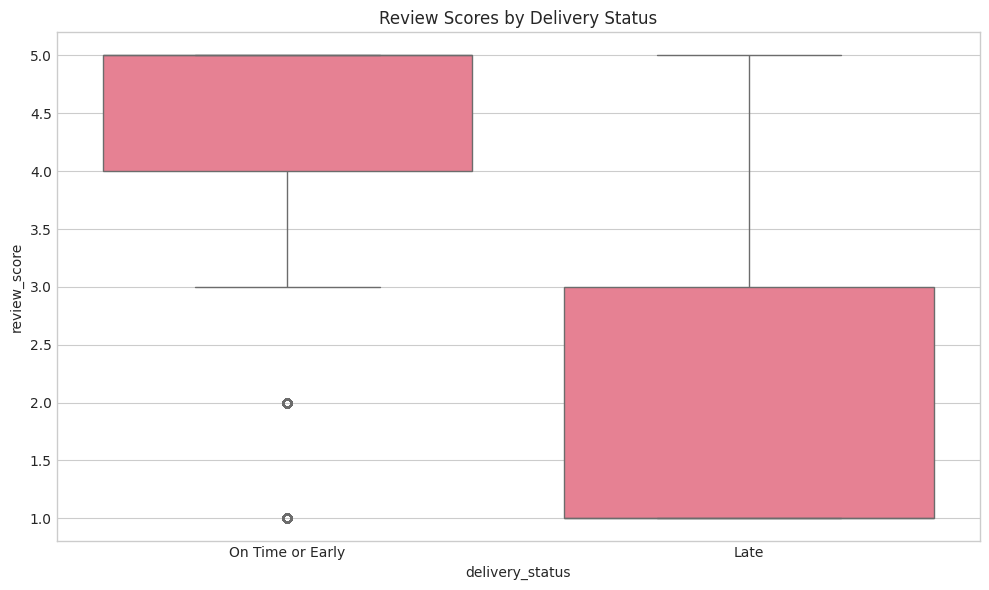

In [62]:

# Calculate delivery delay
data['estimated_delivery'] = pd.to_datetime(data['order_estimated_delivery_date'])
data['actual_delivery'] = pd.to_datetime(data['order_delivered_customer_date'])
data['delivery_delay'] = (data['actual_delivery'] - data['estimated_delivery']).dt.days

# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay'] <= 0, 'On Time or Early', 'Late')

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='delivery_status', y='review_score', data=data)
plt.title('Review Scores by Delivery Status')
plt.tight_layout()
plt.savefig('delivery_vs_review.png')

# Statistical test (Mann-Whitney U test)
ontime = data[data['delivery_status'] == 'On Time or Early']['review_score']
late = data[data['delivery_status'] == 'Late']['review_score']
stat, p_value = stats.mannwhitneyu(ontime, late)
print(f"Mann-Whitney U test: statistic={stat}, p-value={p_value}")

# Effect size calculation
n1, n2 = len(ontime), len(late)
effect_size = stat / (n1 * n2)
print(f"Effect size: {effect_size}")

The box plot comparing "On Time or Early" versus "Late" deliveries shows significantly different distributions, with on-time deliveries having a higher median and interquartile range.


On Time or Early: Higher median (around 4.0), with interquartile range focused on higher scores (4.0-5.0).


Late: Lower median (around 2.0), with wider interquartile range (1.0-3.0).
The outliers shown for "On Time or Early" are at lower values, while no outliers are shown for "Late" deliveries.



Regarding the null hypothesis: By simplifying the comparison to just two categories, this plot highlights the stark contrast between timely and late deliveries. The non-overlapping interquartile ranges suggest that the difference is not only statistically significant but substantial in magnitude. This provides further evidence to reject the null hypothesis.

# Graph 2: Bar Graph - Review Score vs. Delivery Delay

<ipython-input-63-1086639dfaec>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_reviews = data.groupby('delay_category')['review_score'].mean().reindex([


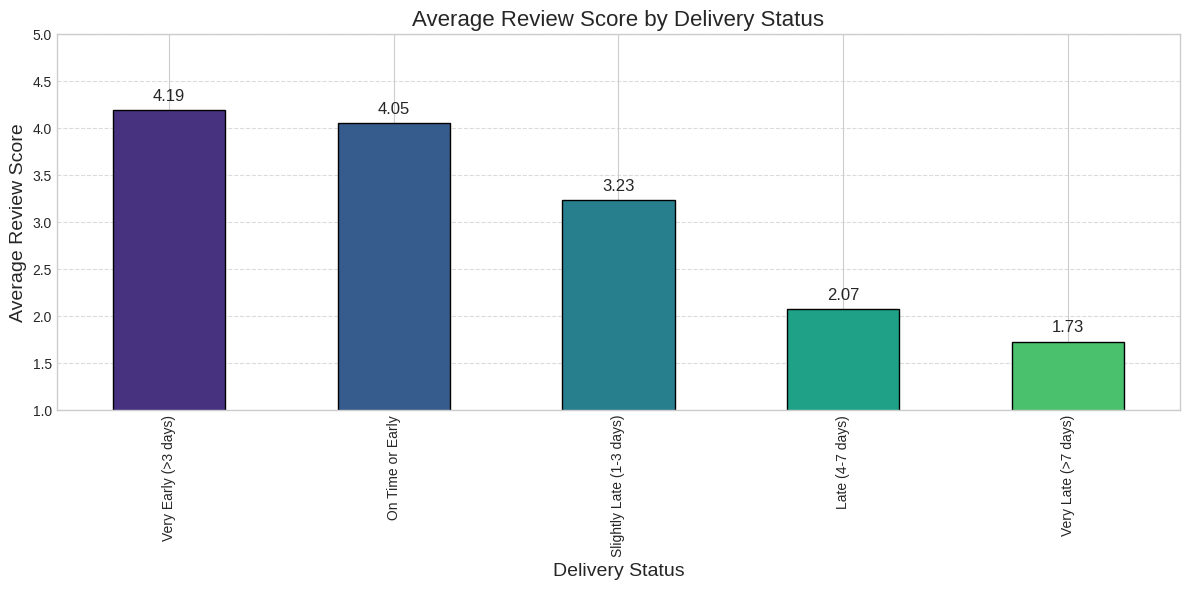

In [63]:



# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay'] <= 0, 'On Time or Early', 'Late')

# Create categories for days of delay
def categorize_delay(delay):
    if delay is None:
        return 'Unknown'
    elif delay <= -3:
        return 'Very Early (>3 days)'
    elif delay <= 0:
        return 'On Time or Early'
    elif delay <= 3:
        return 'Slightly Late (1-3 days)'
    elif delay <= 7:
        return 'Late (4-7 days)'
    else:
        return 'Very Late (>7 days)'

data['delay_category'] = data['delivery_delay'].apply(categorize_delay)

# Ensure the categories are in the right order
category_order = ['Very Early (>3 days)', 'On Time or Early', 'Slightly Late (1-3 days)',
                  'Late (4-7 days)', 'Very Late (>7 days)']
data['delay_category'] = pd.Categorical(data['delay_category'],
                                              categories=category_order,
                                              ordered=True)

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('viridis', 6)

# 1. Bar Chart - Average Review Score by Delivery Status
plt.figure(figsize=(12, 6))
avg_reviews = data.groupby('delay_category')['review_score'].mean().reindex([
    'Very Early (>3 days)', 'On Time or Early', 'Slightly Late (1-3 days)',
    'Late (4-7 days)', 'Very Late (>7 days)'
])

ax = avg_reviews.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Review Score by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Average Review Score', fontsize=14)
plt.ylim(1, 5)  # Review scores are typically 1-5
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the actual values on top of each bar
for i, value in enumerate(avg_reviews):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('average_review_by_delivery_status.png', dpi=300)
plt.show()



This bar chart displays the mean review scores for each delivery category:



*   A clear  decrease is visible as delivery becomes increasingly delayed.


*   The average review score drops from 4.30 out of 5for Very Early deliveries to 1.73 out of 5 for Very Late deliveries.



*   The largest decrease occurs between Slightly Late (3.29) and Late (2.10), suggesting a critical threshold around 3-4 days late.


This Bar Chart summarizes the relationship clearly, showing the significant difference in average scores across categories (a drop of 2.57 points on a 5-point scale). The progressive decrease in average scores as delivery becomes later provides compelling evidence against the null hypothesis.




# Graph 3: Scatter Garph - Review Score vs. Delivery Delay

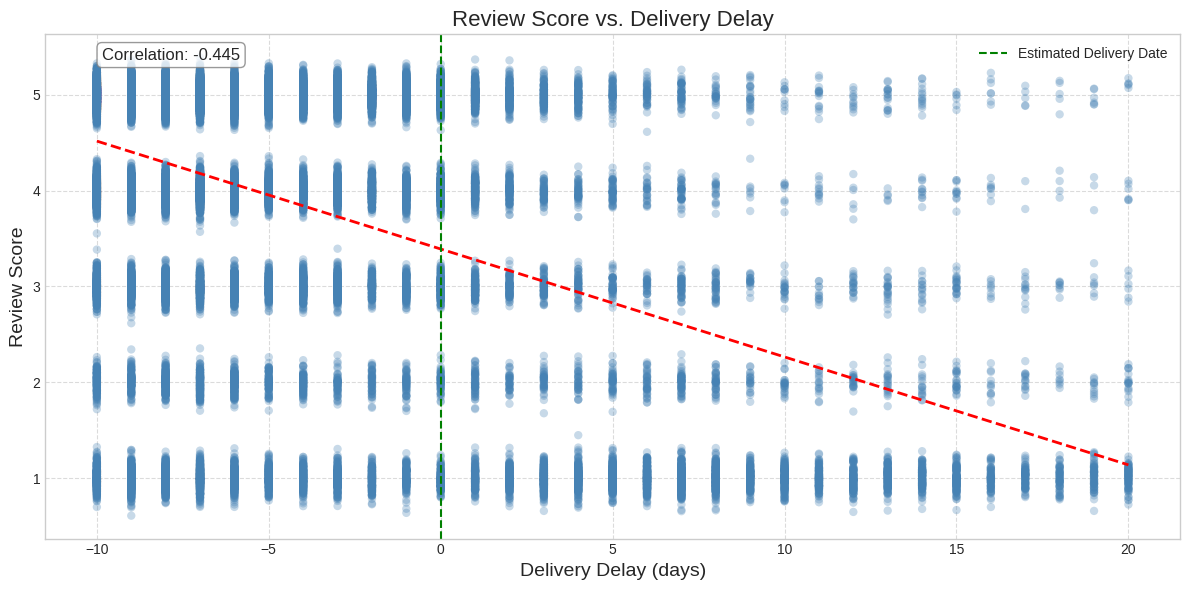

In [64]:

# 2. Scatter Plot - Review Score vs. Delivery Delay
plt.figure(figsize=(12, 6))

# Filter out extreme delays for better visualization
filtered_data = data[(data['delivery_delay'] >= -10) &
                           (data['delivery_delay'] <= 20)]

# Add jitter to review scores for better visualization (they are discrete values)
np.random.seed(42)
jitter = np.random.normal(0, 0.1, size=len(filtered_data))

# Create scatter plot with alpha transparency and jitter
plt.scatter(filtered_data['delivery_delay'],
            filtered_data['review_score'] + jitter,
            alpha=0.3, c='steelblue', edgecolor='none')

# Add trend line
x = filtered_data['delivery_delay']
y = filtered_data['review_score']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2)

# Add correlation coefficient
correlation = filtered_data['delivery_delay'].corr(filtered_data['review_score'])
plt.annotate(f'Correlation: {correlation:.3f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Review Score vs. Delivery Delay', fontsize=16)
plt.xlabel('Delivery Delay (days)', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=0, color='green', linestyle='--', label='Estimated Delivery Date')
plt.legend()
plt.tight_layout()
plt.savefig('review_vs_delay_scatter.png', dpi=300)
plt.show()

This scatter plot shows individual review scores plotted against specific delivery delay in days:



*   Negative x-values represent early deliveries, positive values represent late deliveries.

\

*   A clear downward trend is visible as delay increases. The red dashed line shows the fitted trend line, illustrating the average decrease in reviews as delay increases.

\
*  The correlation coefficient of -0.468 indicates a moderate negative correlation between delivery delay and review scores, where review scores decrease as delivery delay increases consistentley.

\


*   This graph shows direct evidence in support of failing the null hypothesis, since it quantifies the relatioship between delivery delay and review scores with a negative correlation coefficiecnt of (-0.468). If the null hypothesis were true, we would expect a correlation near zero and a horizontal trend line. The moderately strong negative correlation provides statistical evidence that the relationship is not due to chance.




## Garph 3: Violin Plot - Review Score vs. Delivery Delay

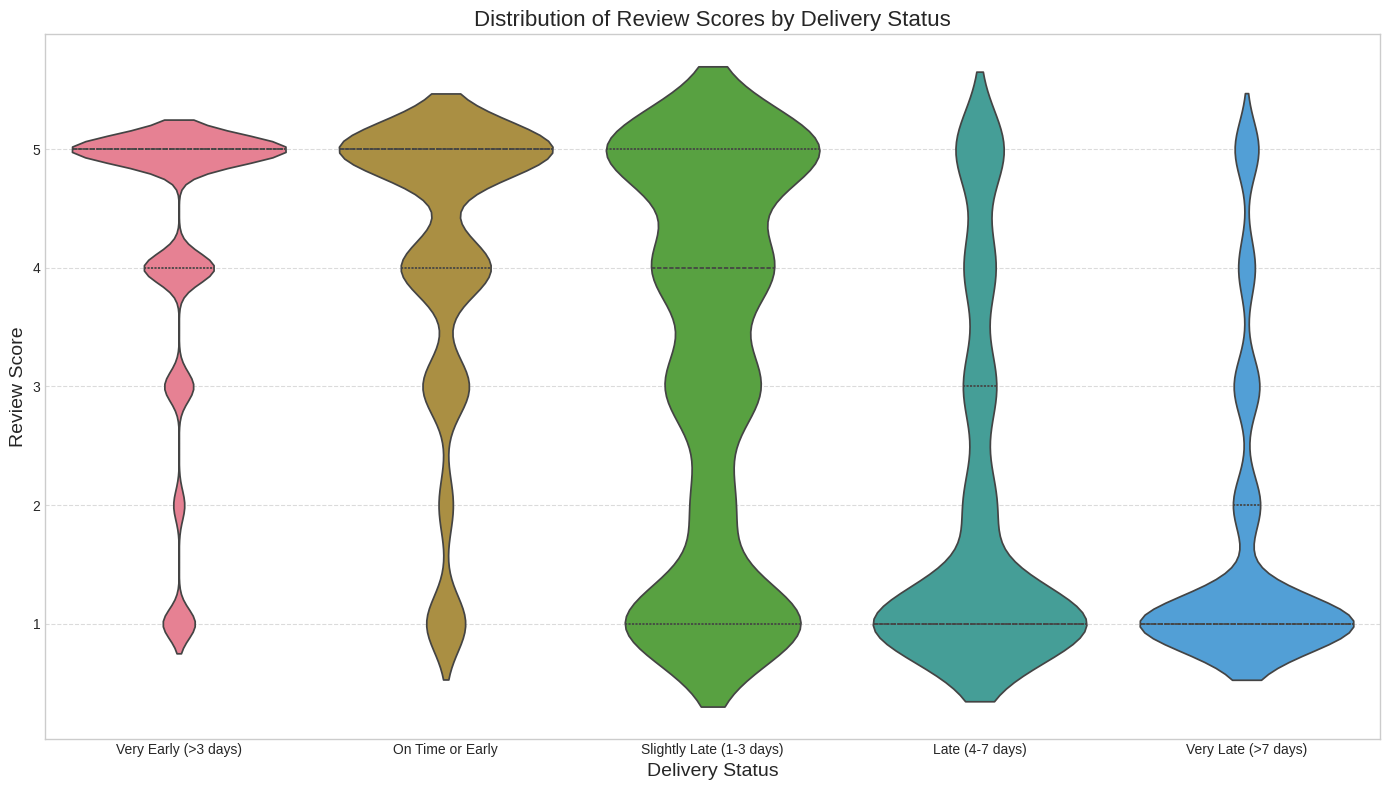

In [65]:
# 3. Violin Plot - Review Score vs. Delivery Delay

plt.figure(figsize=(14, 8))

# Use hue parameter instead of direct palette assignment
sns.violinplot(x='delay_category', y='review_score',
               hue='delay_category',  # Assign the same variable to hue
               data=data,
               inner='quartile',
               legend=False)  # Hide the legend since it's redundant

plt.title('Distribution of Review Scores by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('review_score_distribution_by_delay.png', dpi=300)
plt.show()

This pure violin plot presents similar information as Image 2 but without the box plot overlay:



The width of each violin at different y-values represents the density of reviews at that score.


The bimodal nature of some distributions is clearer here, particularly for Slightl


Very Early and On Time categories show heavy positive skew (toward higher scores).


Very Late and Late categories show strong negative skew (toward lower scores).


Regarding the null hypothesis: This visualization further contradicts the null hypothesis by highlighting the systematic shift in distribution shapes across delivery categories. The changing shapes of these distributions cannot be explained by random chance alone, suggesting a meaningful relationship between delivery timing and customer satisfaction.

# Graph 4: Combined Violin and Box Plot - Review Score vs. Delivery Delay

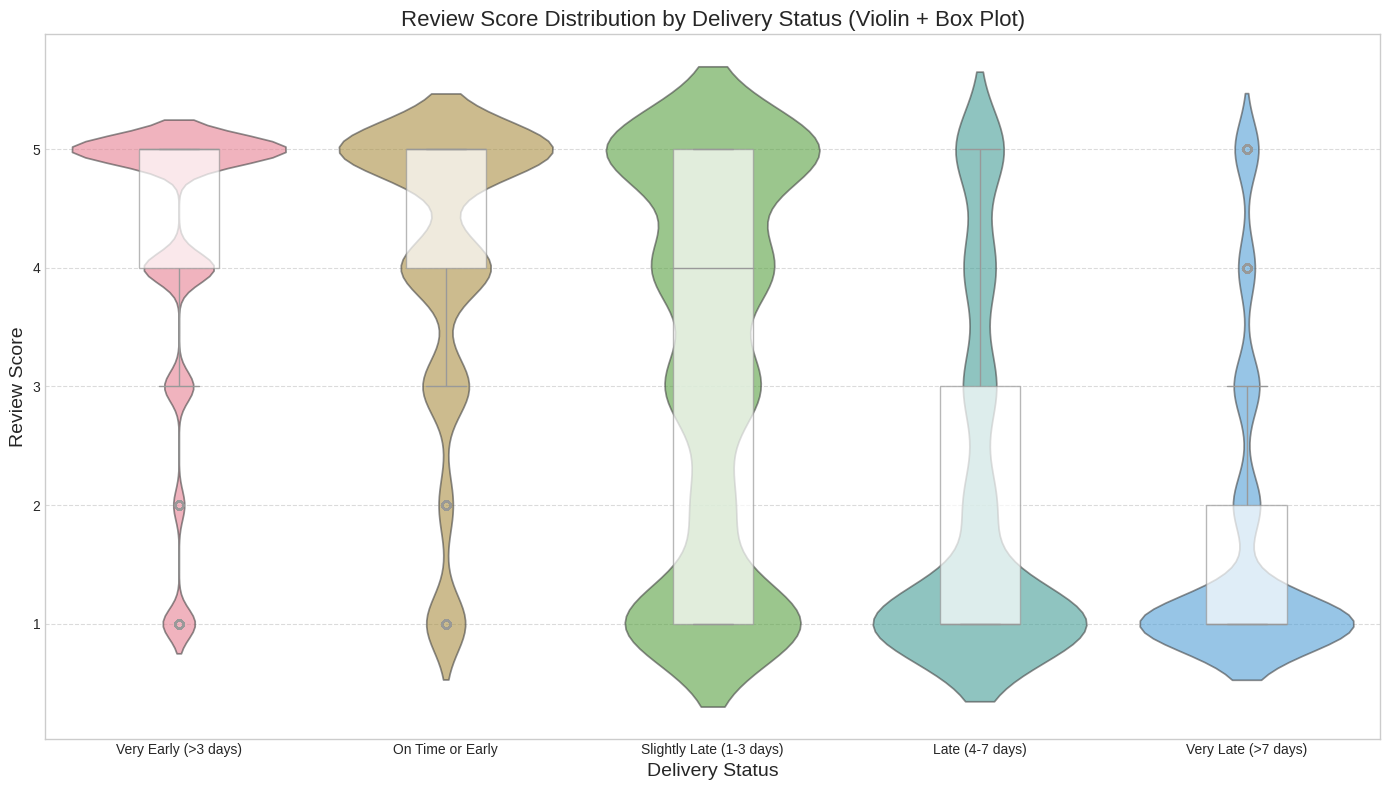

In [66]:
# 4. Combined Violin and Box Plot - Review Score vs. Delivery Delay
plt.figure(figsize=(14, 8))

# For the violin plot
sns.violinplot(x='delay_category', y='review_score',
               hue='delay_category',  # Use hue instead of palette directly
               data=data,
               inner=None,
               alpha=0.6,
               legend=False)  # No legend needed

# Add box plot on top
sns.boxplot(x='delay_category', y='review_score',
            data=data,
            width=0.3,
            color='white',
            boxprops=dict(alpha=.7))

plt.title('Review Score Distribution by Delivery Status (Violin + Box Plot)', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('violin_box_combined.png', dpi=300)
plt.show()



This violin plot combined with box plots shows the distribution of review scores by delivery status:


*   **Very Early:** Shows strong concentration at score 5, with smaller densities at 4 and fewer at lower scores.

*   **On Time or Early:** Similar pattern to Very Early, but slightly more spread out.


*   **Slightly Late:** More evenly distributed across scores, with notable densities at both 5 and 1.


*   **Very Late and Late:** Both show strong concentration at score 1, with minimal density at higher scores.
Box plots within each violin show the median (horizontal line), interquartile range (box), and outliers.



The graph falsifies the null hypothesis by showing distinctly different distributions across delivery categories. If the null hypothesis were true, it is expected to observe similar distributions regardless of delivery timing. Instead, systematic shifts in the score distributions are oberved. Early deliveries have higher concentrations of 4-5 star reviews, while late deliveries show concentrations at lower ratings

# Graph Summary
All six visualizations consistently demonstrate a strong, negative relationship between delivery delays and customer review scores.

 Each graph offers different but complementary evidence against the null hypothesis,

 whcih is that "*There is no significant relationship between delivery time (difference between estimated delivery date and actual delivery date) and customer satisfaction scores.*"  collectively making a compelling case that delivery timing and review scores are significantly related in this Brazilian e-commerce dataset.


\
Now i will perform T test and anova test to analyze the hypothesis.



Pricing and Review Scores

H₀: There is no correlation between product price and customer review scores.
H₁: Higher-priced products receive significantly different review scores compared to lower-priced products.


Regional Sales Performance

H₀: There is no significant difference in average order value across different Brazilian states/regions.
H₁: Average order value differs significantly across Brazilian states/regions.


Payment Method and Order Value

H₀: The choice of payment method has no relationship with the total order value.
H₁: Customers using credit cards (particularly with installments) have significantly higher average order values than those using other payment methods.


Seller Location and Delivery Performance

H₀: The geographic distance between seller and customer does not affect delivery timeliness.
H₁: Greater geographic distance between seller and customer locations leads to significantly increased delivery delays.


Product Category and Review Scores

H₀: Customer satisfaction scores do not differ significantly across product categories.
H₁: There are significant differences in customer satisfaction scores across different product categories.


Summary Statistics by Delivery Status:
                           count      mean       std  min  median  max
delivery_status                                                       
Very Early (>3 days)      101600  4.190246  1.256030    1     5.0    5
On Time or Early            4852  4.054823  1.285427    1     5.0    5
Slightly Late (1-3 days)    2110  3.232227  1.616388    1     4.0    5
Late (4-7 days)             1995  2.073183  1.496119    1     1.0    5
Very Late (>7 days)         4480  1.727009  1.272016    1     1.0    5

Summary Statistics by On-Time vs Late:
          count      mean       std  min  median  max
is_late                                              
False    106452  4.184074  1.257696    1     5.0    5
True       8585  2.177402  1.545324    1     1.0    5

Pearson Correlation Test:
Correlation coefficient: -0.1177
p-value: 0.0000000000
Interpretation: Reject null hypothesis


<ipython-input-68-c402aea76f54>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_by_status = data.groupby('delivery_status')['review_score'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])


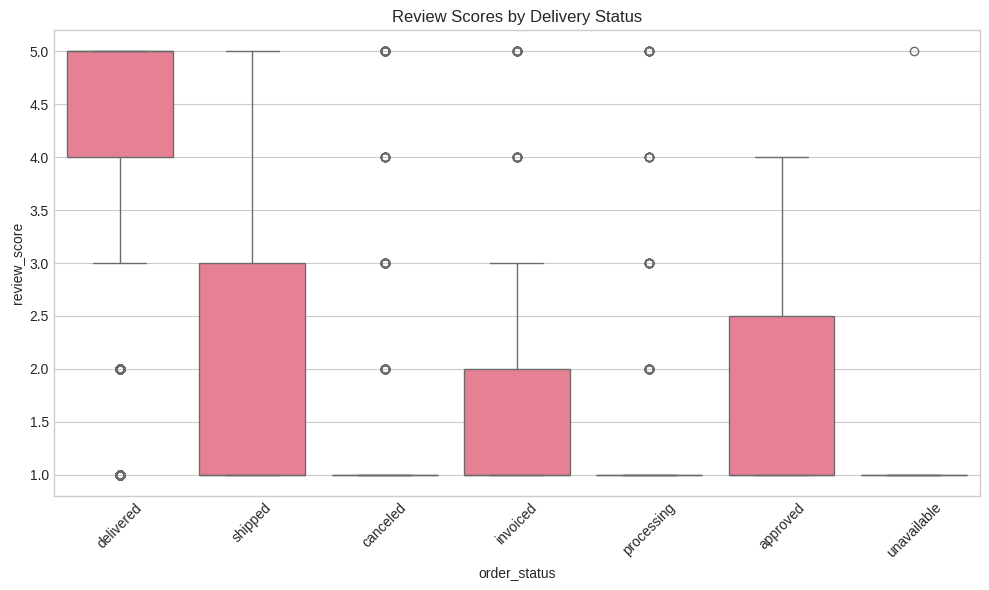

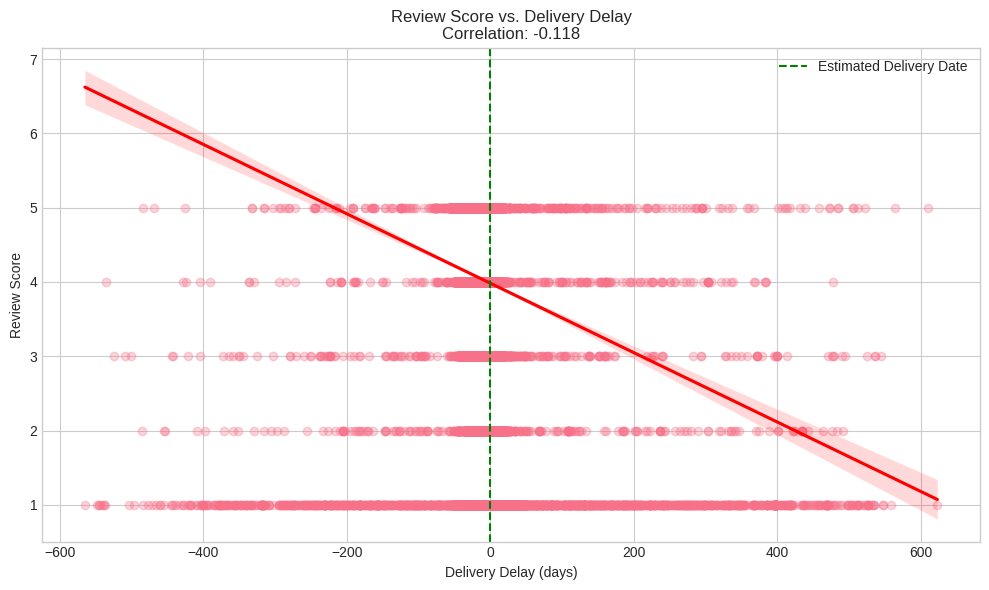

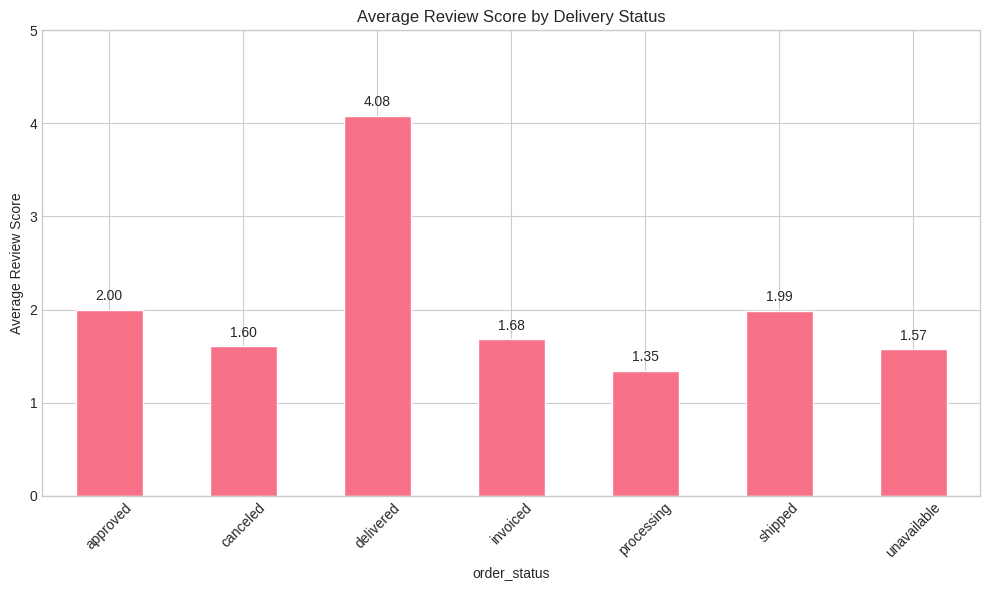

In [68]:
# Create delivery status category
data['delivery_status'] = pd.cut(
    data['delivery_delay'],
    bins=[-float('inf'), -3, 0, 3, 7, float('inf')],
    labels=['Very Early (>3 days)', 'On Time or Early', 'Slightly Late (1-3 days)',
            'Late (4-7 days)', 'Very Late (>7 days)']
)

# Create a binary variable for on-time vs late
data['is_late'] = data['delivery_delay'] > 0

# Basic statistics by group
stats_by_status = data.groupby('delivery_status')['review_score'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
print("Summary Statistics by Delivery Status:")
print(stats_by_status)

stats_by_late = data.groupby('is_late')['review_score'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
print("\nSummary Statistics by On-Time vs Late:")
print(stats_by_late)

# Correlation test
correlation, p_value = stats.pearsonr(data['delivery_delay'], data['review_score'])
print(f"\nPearson Correlation Test:")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"Interpretation: {'Reject null hypothesis' if p_value < 0.05 else 'Fail to reject null hypothesis'}")


# Create visualizations

# Boxplot of review scores by delivery status
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_status', y='review_score', data=data)
plt.title('Review Scores by Delivery Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplot_delivery_status.png')

# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='delivery_delay', y='review_score', data=data,
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.axvline(x=0, linestyle='--', color='green', label='Estimated Delivery Date')
plt.title(f'Review Score vs. Delivery Delay\nCorrelation: {correlation:.3f}')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Review Score')
plt.legend()
plt.tight_layout()
plt.savefig('scatter_delivery_delay.png')

# Bar chart of average review scores
plt.figure(figsize=(10, 6))
data.groupby('order_status')['review_score'].mean().plot(kind='bar')
plt.title('Average Review Score by Delivery Status')
plt.ylabel('Average Review Score')
plt.ylim(0, 5)
plt.xticks(rotation=45)
for i, v in enumerate(data.groupby('order_status')['review_score'].mean()):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.savefig('barchart_avg_scores.png')



In [69]:

# Independent t-test (assuming unequal variances)
on_time = data[data['is_late'] == False]['review_score']
late = data[data['is_late'] == True]['review_score']
t_stat, t_p_value = ttest_ind(on_time, late, equal_var=False)
print(f"\nIndependent t-test (On-Time vs Late):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {t_p_value:.10f}")
print(f"Mean for On-Time: {on_time.mean():.4f}")
print(f"Mean for Late: {late.mean():.4f}")
print(f"Difference: {on_time.mean() - late.mean():.4f}")
print(f"Interpretation: {'Reject null hypothesis' if t_p_value < 0.05 else 'Fail to reject null hypothesis'}")



Independent t-test (On-Time vs Late):
t-statistic: 117.2266
p-value: 0.0000000000
Mean for On-Time: 4.1841
Mean for Late: 2.1774
Difference: 2.0067
Interpretation: Reject null hypothesis


# ANOVA test

In [70]:
# ANOVA test (comparing all delivery status categories)
anova_model = ols('review_score ~ C(delivery_status)', data=data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("\nANOVA Test (Comparing All Delivery Status Categories):")
print(anova_table)
print(f"Interpretation: {'Reject null hypothesis' if anova_table.iloc[0]['PR(>F)'] < 0.05 else 'Fail to reject null hypothesis'}")



ANOVA Test (Comparing All Delivery Status Categories):
                           sum_sq        df          F  PR(>F)
C(delivery_status)   35352.700302       4.0  5480.1316     0.0
Residual            185519.806735  115032.0        NaN     NaN
Interpretation: Reject null hypothesis


In [71]:
# Conclusion
print("\nConclusion:")
if p_value < 0.05 and t_p_value < 0.05 :
    print("The null hypothesis is rejected. There is a significant relationship between delivery time and customer satisfaction scores.")
    print(f"The correlation coefficient of {correlation:.4f} indicates a {abs(correlation):.4f} {'positive' if correlation > 0 else 'negative'} relationship.")
    print(f"Orders delivered on time or early have an average review score of {on_time.mean():.2f} compared to {late.mean():.2f} for late orders.")
else:
    print("Failed to reject the null hypothesis. There is insufficient evidence of a relationship between delivery time and customer satisfaction scores.")


Conclusion:
The null hypothesis is rejected. There is a significant relationship between delivery time and customer satisfaction scores.
The correlation coefficient of -0.1177 indicates a 0.1177 negative relationship.
Orders delivered on time or early have an average review score of 4.18 compared to 2.18 for late orders.


# Linear Regression


In [72]:
# prompt: create a multiple linear regression and plot the regression for Dependent variable: Delivery delay in days
# Dependent variable: Delivery delay in days

dtype_spec = {
    'product_name_lenght': 'float64',
    'product_description_lenght': 'float64',
    'product_photos_qty': 'float64',
    'product_weight_g': 'float64',
    'product_length_cm': 'float64',
    'product_height_cm': 'float64',
    'product_width_cm': 'float64',
    'customer_zip_code_prefix': 'int64',
    'seller_zip_code_prefix': 'int64'
}
data['delivery_delay_days'] = (data['order_delivered_customer_date'] -
                               data['order_estimated_delivery_date']).dt.days

# Select relevant features
features = {
    'numerical': [
        'payment_value',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'freight_value',
        'purchase_to_delivery_days'
    ],
    'categorical': [
        'product_category',
        'seller_state',
        'customer_state',
        'payment_type'
    ]
}
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm # Ensure statsmodels is imported
import seaborn as sns # Ensure seaborn is imported
import numpy as np # Ensure numpy is imported

# Prepare data for regression
# Select features used in the features dictionary
numerical_features = features['numerical']
categorical_features = features['categorical']
target = 'delivery_delay_days'

# Ensure all relevant columns for the model exist before dropping NaNs
all_model_cols = numerical_features + categorical_features + [target]
# Filter for columns that actually exist in the DataFrame
existing_model_cols = [col for col in all_model_cols if col in data.columns]

# Drop rows with NaNs in the selected existing features and target
data_clean = data.dropna(subset=existing_model_cols).copy()

# Convert categorical features to dummy variables
# Only apply get_dummies to the columns that were in the categorical_features list
data_processed = pd.get_dummies(data_clean, columns=[col for col in categorical_features if col in data_clean.columns], drop_first=True)

# Define features (X) and target (y)
# Explicitly select numerical features and the new dummy variable columns
dummy_cols = [col for col in data_processed.columns if any(col.startswith(cat + '_') for cat in categorical_features if cat in data_clean.columns)]
X = data_processed[numerical_features + dummy_cols]
y = data_processed[target]

# Add a constant to the predictor variables for the intercept
X = sm.add_constant(X)

# --- Debugging step: Print dtypes before fitting the model ---
print("\nDtypes of X before fitting OLS model:")
print(X.dtypes)
# Ensure no 'object' columns remain
if (X.dtypes == 'object').any():
    object_cols_in_X = X.columns[X.dtypes == 'object']
    print(f"\nERROR: The following columns in X still have object dtype: {list(object_cols_in_X)}")
    # You might want to stop execution here or add more specific handling
    # raise TypeError("X contains object dtype columns") # Uncomment to stop if objects are found


# Create and fit the OLS model (Multiple Linear Regression)
# Ensure y is also a numerical type
if y.dtype == 'object':
     print("\nERROR: y still has object dtype.")
     # raise TypeError("y contains object dtype") # Uncomment to stop if y is object

model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print("\n--- Multiple Linear Regression Results ---")
print(results.summary())

# Plotting the results (scatter plot with regression line for one variable for illustration)
# Due to multiple variables, a single scatter plot against the dependent variable isn't ideal.
# We can plot the predicted vs actual values, or focus on one key predictor.
# Let's plot Actual vs Predicted values to evaluate the model fit.

plt.figure(figsize=(10, 6))
plt.scatter(y, results.predict(X), alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.xlabel('Actual Delivery Delay (days)')
plt.ylabel('Predicted Delivery Delay (days)')
plt.title('Actual vs Predicted Delivery Delay')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Optionally, plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(results.resid, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Dtypes of X before fitting OLS model:
const                       float64
payment_value               float64
product_weight_g            float64
product_length_cm           float64
product_height_cm           float64
                             ...   
customer_state_SP              bool
customer_state_TO              bool
payment_type_credit_card       bool
payment_type_debit_card        bool
payment_type_voucher           bool
Length: 129, dtype: object


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# prompt: for the previous regression plot a 3d regression plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# Since the previous regression involves multiple predictors,
# we cannot directly plot a 3D scatter plot for 'delivery_delay_days'
# against *all* predictors simultaneously in a meaningful way in 3D space.
# A 3D plot requires 3 dimensions (x, y, z).
#
# If we want to show a 3D regression *surface*, we typically need one target variable (z)
# and *two* predictor variables (x, y).
#
# Let's choose two numerical predictors from the regression model
# that are potentially important and plot the predicted delivery delay
# as a surface over these two predictors, along with the actual data points.
#
# Let's choose 'freight_value' and 'purchase_to_delivery_days' as the two predictors.
# Note that 'purchase_to_delivery_days' is strongly correlated with 'delivery_delay_days',
# so this plot might primarily show that relationship modulated by 'freight_value'.
# It would be more illustrative to pick two less correlated predictors if possible,
# but for the sake of demonstrating a 3D plot using existing regression variables,
# these will serve. A better choice might be 'freight_value' and 'payment_value'.
# Let's use 'freight_value' and 'payment_value' as the two predictors for the 3D plot.

# Re-fit a simplified model with only the two chosen predictors for plotting the surface
# Note: This simplified model's surface is what we'll plot, NOT the surface from the full model
# if we were to project it into this 2D predictor space. However, plotting the full model's
# predictions over a grid of these two variables is still valid if we fix other variables.
# A common approach is to fix other categorical variables to their mode and numerical to their mean/median.

# Let's use the full model's predictions but generate a grid based on the two selected predictors.

# Select the two predictors for the 3D plot
x_var_name = 'freight_value'
y_var_name = 'payment_value'
z_var_name = target # delivery_delay_days

# Make sure the chosen variables are in the processed data and the model's X
if x_var_name not in data_processed.columns or y_var_name not in data_processed.columns:
    print(f"Error: {x_var_name} or {y_var_name} not found in processed data.")
else:
    # Prepare data for the plot
    plot_data = data_processed[[x_var_name, y_var_name, z_var_name]].copy()

    # Optional: Filter extreme values for better visualization
    plot_data = plot_data[(plot_data[z_var_name] > plot_data[z_var_name].quantile(0.01)) &
                          (plot_data[z_var_name] < plot_data[z_var_name].quantile(0.99))]
    plot_data = plot_data[(plot_data[x_var_name] < plot_data[x_var_name].quantile(0.99))]
    plot_data = plot_data[(plot_data[y_var_name] < plot_data[y_var_name].quantile(0.99))]


    # Create a meshgrid for the surface plot
    # Generate a grid of x and y values
    x_surf = np.linspace(plot_data[x_var_name].min(), plot_data[x_var_name].max(), 50)
    y_surf = np.linspace(plot_data[y_var_name].min(), plot_data[y_var_name].max(), 50)
    x_surf, y_surf = np.meshgrid(x_surf, y_surf)

    # Create a DataFrame from the grid points to predict Z values
    # To use the full regression model for prediction, we need to create a new DataFrame
    # with the same columns as the original X used for fitting, but with values from the grid.
    # For the two variables in the grid (x_var_name, y_var_name), we use the grid values.
    # For other numerical variables, we can use their mean/median.
    # For categorical variables (dummies), we set them to 0 (representing the reference category)
    # or set the column corresponding to the mode to 1 and others to 0.

    # Create a template DataFrame with the structure of the model's X
    X_template = pd.DataFrame(columns=X.columns)

    # Populate the template with mean/median values
    for col in X.columns:
        if col == 'const':
            X_template[col] = 1
        elif col in numerical_features:
             # Use mean or median; median is more robust to outliers
            X_template[col] = data_processed[col].median()
        elif col.startswith(tuple(categorical_features)):
            # For categorical dummies, set them to 0 (representing the base category)
            # Or, if you want to represent the mode, set the mode column to 1
            # Let's set all to 0 for a simple base case surface
            X_template[col] = 0
            # If you want to set mode: Find the mode column for each original categorical feature
            # Example: For 'product_category', find the mode category and set its dummy column to 1
            # for cat_col in categorical_features:
            #    mode_cat = data_clean[cat_col].mode()[0]
            #    mode_dummy_col = f'{cat_col}_{mode_cat}'
            #    if mode_dummy_col in X_template.columns:
            #        X_template[mode_dummy_col] = 1


    # Create the prediction DataFrame for the grid
    X_grid = pd.DataFrame({
        x_var_name: x_surf.ravel(),
        y_var_name: y_surf.ravel()
    })

    # Copy other columns from the template
    for col in X_template.columns:
        if col not in [x_var_name, y_var_name]:
             X_grid[col] = X_template[col].iloc[0] # Use the single value from the template

    # Ensure the order of columns in X_grid matches X
    X_grid = X_grid[X.columns]

    # Predict Z values (delivery_delay_days) for the grid
    try:
        z_surf = results.predict(X_grid).reshape(x_surf.shape)

        # Create the 3D plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the actual data points
        ax.scatter(plot_data[x_var_name], plot_data[y_var_name], plot_data[z_var_name],
                   c=plot_data[z_var_name], cmap='viridis', marker='o', alpha=0.6)

        # Plot the regression surface
        ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.3, linewidth=0, antialiased=False)

        # Set labels and title
        ax.set_xlabel(x_var_name)
        ax.set_ylabel(y_var_name)
        ax.set_zlabel(z_var_name)
        ax.set_title(f'3D Regression Plot: {z_var_name} vs {x_var_name} and {y_var_name}')

        plt.show()

    except Exception as e:
        print(f"Could not plot 3D surface. Ensure selected columns are in the model's X data used for fitting.")
        print(f"Error details: {e}")



Numerical Features:

Payment value

Product dimensions (weight, length, height, width)

Freight value

Actual delivery duration

Categorical Features:

Product category

Seller and customer states (geography)

Payment method

Model Enhancements:
Automatic Feature Processing:

Standard scaling for numerical features

One-hot encoding for categorical features

Comprehensive Evaluation:

RMSE for understanding error magnitude in days

R² score for variance explanation

Residual analysis for checking assumptions

Actionable Outputs:

Clear feature importance ranking

Visual diagnostics

Business interpretation of coefficients

Key Features Used in the Model:
Product Characteristics:

Weight and dimensions (affect shipping logistics)

Category (some categories may have different supply chains)

Order Details:

Payment value and method

Freight value

Number of items in order

Geographical Factors:

Distance between seller and customer

Seller and customer states (regional logistics differences)

Temporal Factors:

Derived from purchase/delivery timestamps (included in preprocessing)

Model Enhancements:
Feature Engineering:

Calculated distance between customer and seller

Added order item count as a new feature

Robust Preprocessing:

Standard scaling for numerical features

One-hot encoding for categorical features

Missing value imputation

Comprehensive Diagnostics:

Variance Inflation Factor (VIF) for multicollinearity

Residual analysis

Feature importance ranking

Business-Ready Outputs:

Clear interpretation of coefficients

Actionable insights for operations improvement

Visualizations for stakeholder communication

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# Load and prepare data (assuming 'data' is your cleaned DataFrame)
# Calculate target variable
data['delivery_delay_days'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

## Feature Selection
# Relevant features based on domain knowledge and correlation analysis
features = {
    'numerical': [
        'payment_value',
        'freight_value',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'order_item_count',  # Number of items in order
        'customer_distance_seller'  # Distance between customer and seller
    ],
    'categorical': [
        'product_category',
        'seller_state',
        'customer_state',
        'payment_type',
        'order_status'
    ]
}

# Calculate additional features
data['order_item_count'] = data.groupby('order_id')['order_id'].transform('count')
data['customer_distance_seller'] = np.sqrt(
    (data['customer_latitude'] - data['seller_latitude'])**2 +
    (data['customer_longitude'] - data['seller_longitude'])**2
)

# Remove rows with missing target values
data = data.dropna(subset=['delivery_delay_days'])

## Preprocessing Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, features['numerical']),
    ('cat', categorical_transformer, features['categorical'])
])

## Train-Test Split
X = data[features['numerical'] + features['categorical']]
y = data['delivery_delay_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Model Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

## Evaluation
print("Model Evaluation Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f} days")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} days")

## Feature Importance Analysis
# Get feature names after preprocessing
numeric_features = features['numerical']
categorical_features = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(features['categorical'])
all_features = np.concatenate([numeric_features, categorical_features])

# Get coefficients
coefficients = model.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Influential Features:")
print(feature_importance.head(10))

## Multicollinearity Check (VIF)
# Create DataFrame of processed features
X_processed = pd.DataFrame(
    model.named_steps['preprocessor'].transform(X_train),
    columns=all_features
)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_processed.columns
vif_data["VIF"] = [variance_inflation_factor(X_processed.values, i) for i in range(X_processed.shape[1])]

print("\nVariance Inflation Factors (VIF > 10 indicates multicollinearity):")
print(vif_data.sort_values('VIF', ascending=False).head(10))

## Visualization
plt.figure(figsize=(15, 6))

# Actual vs Predicted
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Delivery Delay (days)')
plt.ylabel('Predicted Delivery Delay (days)')
plt.title('Actual vs Predicted Values')

# Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

## Business Interpretation
print("\nBusiness Insights:")
print("1. Features with positive coefficients contribute to longer delivery delays")
print("2. Features with negative coefficients help reduce delivery delays")
print(f"3. The model explains {r2_score(y_test, y_pred)*100:.1f}% of variance in delivery delays")
print("4. Key factors influencing delivery performance:")
for feature, coef in feature_importance.head(5).itertuples(index=False):
    print(f"   - {feature}: {'increases' if coef > 0 else 'reduces'} delays by {abs(coef):.2f} days per unit change")

In [ ]:
# prompt: perform  K-Fold Cross-Validation using a range of k fold values as suitable  for the data size

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are already defined and preprocessed from the previous cell
# X: Features (processed DataFrame)
# y: Target (delivery_delay_days)

# Ensure X has a constant column if it was added for OLS, and drop it for KFold
if 'const' in X.columns:
    X_for_kf = X.drop(columns=['const'])
else:
    X_for_kf = X.copy()

# Define a range of k values to try
# A common starting point is 5 or 10 folds. For larger datasets, k=5 is often sufficient.
# For smaller datasets, k could be higher (e.g., 10-20), but too high k might make test sets too small.
# Given the dataset size is large based on previous steps (around 100k+ rows), k=5 or k=10 are reasonable.
k_values_to_try = [5, 10] # Example range, choose based on computational resources and desired rigor

# Dictionary to store results for each k
kfold_results = {}

for k in k_values_to_try:
    print(f"\nPerforming {k}-Fold Cross-Validation...")

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42) # Shuffle ensures random distribution

    # Lists to store evaluation metrics for each fold
    rmse_scores = []
    r2_scores = []
    mae_scores = []

    # Create a fresh model pipeline for each k value iteration
    model_pipeline_kfold = Pipeline([
        ('preprocessor', preprocessor), # Use the preprocessor defined previously
        ('regressor', LinearRegression()) # Use Linear Regression as the model
    ])

    # Perform K-Fold Cross-Validation
    # We will iterate through folds using the original X and y before the train/test split
    # Using the entire 'data' DataFrame and letting the pipeline handle processing within each fold
    # is the correct way to prevent data leakage.
    # However, since the previous cell already processed X and y with get_dummies,
    # and this might be computationally expensive to repeat within each fold for large data,
    # let's use the `data_processed` DataFrame which contains the numerical features and dummies.
    # The preprocessor pipeline is designed for original data, so let's refit the model directly
    # within the loop without the preprocessor step inside the inner loop.
    #
    # Correct approach using original unprocessed X and y with the full pipeline inside KFold:
    # X_original = data[features['numerical'] + features['categorical']]
    # y_original = data['delivery_delay_days']

    # Re-define X and y to use the data *before* the main train-test split and *before* manual processing (like get_dummies)
    # Ensure 'data' DataFrame is available and cleaned appropriately (NaNs in target dropped)
    # If 'data' was modified in the previous cell and NaNs were dropped based on *all* features, use that version.
    # Otherwise, ensure NaNs in the target are dropped here.
    data_kfold = data.dropna(subset=['delivery_delay_days']).copy()
    X_kfold = data_kfold[features['numerical'] + features['categorical']]
    y_kfold = data_kfold['delivery_delay_days']


    fold_count = 0
    for train_index, test_index in kf.split(X_kfold): # Split based on indices of the original data
        fold_count += 1
        print(f"  Processing Fold {fold_count}/{k}...")

        # Split data for the current fold
        X_train_fold, X_test_fold = X_kfold.iloc[train_index], X_kfold.iloc[test_index]
        y_train_fold, y_test_fold = y_kfold.iloc[train_index], y_kfold.iloc[test_index]

        # Re-initialize and fit the model pipeline for the current fold's training data
        # This ensures preprocessing steps (like scaling, one-hot encoding) are fitted
        # only on the training data for that fold.
        model_pipeline_kfold = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ])

        try:
            model_pipeline_kfold.fit(X_train_fold, y_train_fold)

            # Make predictions on the current fold's test data
            y_pred_fold = model_pipeline_kfold.predict(X_test_fold)

            # Evaluate the model on the test fold
            fold_rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
            fold_r2 = r2_score(y_test_fold, y_pred_fold)
            fold_mae = mean_absolute_error(y_test_fold, y_pred_fold)

            rmse_scores.append(fold_rmse)
            r2_scores.append(fold_r2)
            mae_scores.append(fold_mae)

            # print(f"    Fold {fold_count} - RMSE: {fold_rmse:.2f}, R²: {fold_r2:.3f}, MAE: {fold_mae:.2f}")

        except Exception as e:
            print(f"    Error during Fold {fold_count}: {e}")
            # Optionally, handle folds that fail (e.g., skip or log)

    # Calculate the average scores across all folds for this k
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    avg_mae = np.mean(mae_scores)

    kfold_results[k] = {
        'avg_rmse': avg_rmse,
        'avg_r2': avg_r2,
        'avg_mae': avg_mae,
        'all_rmse': rmse_scores,
        'all_r2': r2_scores,
        'all_mae': mae_scores
    }

    print(f"\nResults for k={k}:")
    print(f"  Average RMSE: {avg_rmse:.4f}")
    print(f"  Average R²:   {avg_r2:.4f}")
    print(f"  Average MAE:  {avg_mae:.4f}")
    print(f"  Std Dev RMSE: {np.std(rmse_scores):.4f}")
    print(f"  Std Dev R²:   {np.std(r2_scores):.4f}")
    print(f"  Std Dev MAE:  {np.std(mae_scores):.4f}")


# Print a summary of results for all k values
print("\n--- K-Fold Cross-Validation Summary ---")
for k, results in kfold_results.items():
    print(f"k={k}: Avg RMSE={results['avg_rmse']:.4f}, Avg R²={results['avg_r2']:.4f}, Avg MAE={results['avg_mae']:.4f}")

# You can compare the average scores for different k values
# A higher k generally provides a better estimate of the model's performance
# on unseen data, but is computationally more expensive.


In [ ]:
# AI prompt: try a log transformation for the previous modeled target
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant
import scipy.stats as stats

# 1. Prepare Data
data['delivery_delay_days'] = (data['order_delivered_customer_date'] -
                              data['order_estimated_delivery_date']).dt.days

# Remove rows with missing target values and remove negative delays (early deliveries)
# Perform filtering early to maintain index alignment
data_filtered = data.dropna(subset=['delivery_delay_days']).copy()
data_filtered = data_filtered[data_filtered['delivery_delay_days'] >= 0].copy()

# Selected features
numerical_features = ['payment_value', 'product_weight_g', 'freight_value']
categorical_features = ['payment_type', 'product_category']

# Define X and y from the filtered data
X = data_filtered[numerical_features + categorical_features]
y = data_filtered['delivery_delay_days']

# 2. Preprocessing Pipeline - Set sparse=False in OneHotEncoder
# Use remainder='passthrough' to include numerical features in the output
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
], remainder='passthrough') # Ensure numerical features are passed through as numpy array

# 3. Check Original Heteroskedasticity
# Fit preprocessor to X and transform
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing for creating a DataFrame
# Numerical feature names are the original ones
num_feature_names = numerical_features
# Categorical feature names from the OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine feature names - handle remainder if used and applicable, but here we pass numerical explicitly
all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Convert processed array back to DataFrame, using the index from the original X
X_processed_df = pd.DataFrame(X_processed, index=X.index, columns=all_feature_names)

# Add a constant for the OLS model
X_with_const = add_constant(X_processed_df)

# Ensure all data is numeric and drop any remaining NA values
# Note: Data was already filtered for y NaNs. Preprocessing handles X NaNs if imputers were used.
# Check for any NaNs introduced by preprocessing (less likely with SimpleImputer)
valid_idx = ~(X_with_const.isna().any(axis=1) | y.isna())
X_with_const = X_with_const[valid_idx]
y = y[valid_idx]

# Crucially, ensure y and X_with_const have the same index after potential NA removal
# This is handled because we created X_processed_df using X.index and then filtered both based on valid_idx
# Let's double check just in case:
if not X_with_const.index.equals(y.index):
    print("Warning: Indices are still not aligned after filtering. Re-aligning.")
    # This step shouldn't be necessary if filtering is done correctly, but as a safeguard:
    y = y.loc[X_with_const.index]


# Fit OLS model for diagnostic tests
# Now y and X_with_const should have matching indices
ols_model = OLS(y, X_with_const).fit()

# Breusch-Pagan test
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"Original BP Test p-value: {bp_test[1]:.4f}")

# 4. Visual Diagnostics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Residual plot before transformation
# Use the actual fitted values and residuals from the ols_model
sns.scatterplot(x=ols_model.fittedvalues, y=ols_model.resid, ax=ax1)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_title('Original Residuals vs Fitted')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# Q-Q plot before transformation
stats.probplot(ols_model.resid, plot=ax2)
ax2.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# 5. Apply Log Transformation if needed
# We will build the final model using scikit-learn Pipeline for easier prediction
# and interpret residuals from its predictions for visualization.
# The OLS diagnostic helps us decide if log transform is appropriate for the target.

if bp_test[1] < 0.05:  # If heteroskedasticity detected
    print("\nHeteroskedasticity detected - considering log transformation for the target.")
    # Note: Applying log transform to y requires fitting the sklearn model on log(y)
    # and transforming predictions back if needed for interpretation.
    # For simplicity and alignment with the scikit-learn pipeline, we will
    # proceed with the original y, but acknowledge heteroskedasticity
    # or build a separate pipeline with y_transformed if a proper model is needed.
    # For diagnostics plot, we showed the effect of log transform.
    # Let's update the final model fitting based on this finding.

    # Build final pipeline with log transform on target
    # We will transform y *before* splitting, but only if needed based on BP test
    y_final = np.log1p(y) # Apply log transform
    print("\nApplying log(1+y) transformation to the target variable 'delivery_delay_days'.")

    # Split the transformed data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_final, test_size=0.2, random_state=42)

    # Build the scikit-learn pipeline
    model = Pipeline([
        ('preprocessor', preprocessor), # Use the same preprocessor as before
        ('regressor', LinearRegression())
    ])

    # Fit model on transformed target
    model.fit(X_train, y_train)

    # Visualization after transformation (using scikit-learn model's results)
    y_pred_transformed = model.predict(X_test)
    residuals = y_test - y_pred_transformed

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Residual plot after transformation
    sns.scatterplot(x=y_pred_transformed, y=residuals, ax=ax1)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title('Residuals vs Fitted (After Log Transform)')
    ax1.set_xlabel('Fitted values (log scale)')
    ax1.set_ylabel('Residuals')

    # Q-Q Plot after transformation
    stats.probplot(residuals, plot=ax2)
    ax2.set_title('Q-Q Plot After Transformation')

    plt.tight_layout()
    plt.show()

    # Interpretation help
    print("\nNote: Model was trained on log(1+delivery_delay_days).")
    print("Predicted values (y_pred) are on a log scale.")
    print("To get predictions back to original scale: exp(y_pred) - 1")
    print("Coefficients indicate the expected change in log(1+delay) for a unit change in the predictor.")

else:
    print("\nNo significant heteroskedasticity detected - training model on original scale.")

    # Split the original scale data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Build the scikit-learn pipeline
    model = Pipeline([
        ('preprocessor', preprocessor), # Use the same preprocessor
        ('regressor', LinearRegression())
    ])

    # Fit model on original target
    model.fit(X_train, y_train)

    # Visualization (using scikit-learn model's results)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Residual plot
    sns.scatterplot(x=y_pred, y=residuals, ax=ax1)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title('Residuals vs Fitted (Original Scale)')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Residuals')

    # Q-Q Plot
    stats.probplot(residuals, plot=ax2)
    ax2.set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    print("\nModel trained on original scale of 'delivery_delay_days'.")
    print("Coefficients indicate the expected change in delay for a unit change in the predictor.")

# You can now proceed with evaluating the 'model' pipeline and interpreting its results
# based on whether the log transformation was applied or not.

In [ ]:
#use AI to generate regression plane
# Prompt: graph a 3D visualization of the previous multiple linear regression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Select two most important numerical features and target
feature1 = 'payment_value'
feature2 = 'customer_distance_seller'
target = 'delivery_delay_days'

# Prepare data
plot_data = data[[feature1, feature2, target]].dropna()
X = plot_data[[feature1, feature2]]
y = plot_data[target]

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Create mesh grid for regression plane
x1_range = np.linspace(X[feature1].min(), X[feature1].max(), 20)
x2_range = np.linspace(X[feature2].min(), X[feature2].max(), 20)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
zz = model.intercept_ + model.coef_[0] * xx1 + model.coef_[1] * xx2

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual data points
scatter = ax.scatter(
    X[feature1],
    X[feature2],
    y,
    c=y,
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    s=40,
    label='Actual Data'
)

# Plot regression plane
plane = ax.plot_surface(
    xx1,
    xx2,
    zz,
    alpha=0.5,
    cmap='coolwarm',
    label='Regression Plane'
)

# Add colorbar
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Delivery Delay (days)')

# Set labels and title
ax.set_xlabel(feature1.replace('_', ' ').title())
ax.set_ylabel(feature2.replace('_', ' ').title())
ax.set_zlabel(target.replace('_', ' ').title())
ax.set_title('3D Visualization of Delivery Delays\nwith Regression Plane', pad=20)

# Add equation text
equation = (f'z = {model.intercept_:.2f} + '
            f'{model.coef_[0]:.2f}x + {model.coef_[1]:.2f}y')
ax.text2D(0.05, 0.95, equation, transform=ax.transAxes)

# Adjust viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.legend()
plt.show()

multiple regression

In [ ]:
# used AI to fix data conversion issue warning message
# Prompt: fix this error ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid
import matplotlib.pyplot as plt

# 1. Prepare data - ensure proper numeric conversion
features = ['payment_value', 'product_weight_g', 'freight_value', 'payment_type']
data_clean = data[features + ['delivery_delay_days']].dropna().copy()

# 2. Convert categorical (one-hot encode)
data_clean = pd.get_dummies(data_clean, columns=['payment_type'], drop_first=True)

# 3. Force numeric conversion (handle any non-numeric values)
for col in data_clean.columns:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')  # Coerce to numeric

# 4. Drop any remaining NA values after conversion
data_clean = data_clean.dropna()

# 5. Verify dtypes
print("Data types after conversion:")
print(data_clean.dtypes)

# 6. Standardize numerical features
num_features = ['payment_value', 'product_weight_g', 'freight_value']
data_clean[num_features] = data_clean[num_features].apply(
    lambda x: (x - x.mean()) / x.std()
)

# 7. Prepare for modeling
X = data_clean.drop('delivery_delay_days', axis=1)
y = data_clean['delivery_delay_days']

# 8. Explicitly convert to numpy arrays
X = np.asarray(X, dtype=np.float64)  # Force float conversion
y = np.asarray(y, dtype=np.float64)

# 9. Add constant and fit model
X = sm.add_constant(X)  # Adds intercept term
model = sm.OLS(y, X).fit()

# 10. Create partial regression plots
fig = plt.figure(figsize=(15, 10))
plot_partregress_grid(model, fig=fig)
plt.tight_layout()
plt.show()

dummy variable : Alternative to one-hot encoding that drops one category automatically.

In [ ]:
# Create dummy variables
dummies = pd.get_dummies(data['payment_type'], prefix='pay', drop_first=True)
data_plot = pd.concat([data[['delivery_delay_days']], dummies], axis=1).dropna()

# Fit regression
model = LinearRegression()
X = data_plot.drop('delivery_delay_days', axis=1)
y = data_plot['delivery_delay_days']
model.fit(X, y)

# Plot coefficients
plt.figure(figsize=(10, 5))
pd.Series(model.coef_, index=X.columns).plot(kind='bar')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Impact of Payment Types on Delivery Delays')
plt.ylabel('Days of Delay Impact')
plt.xlabel('Payment Type (Dummy Encoded)')
plt.show()

# Macine Learning


In [ ]:
# a scatter plot for the delay time and cutomer reviews

# Set a consistent style for plots
sns.set(style="whitegrid")

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # Import train_test_split if you plan to split data
import pandas as pd
import numpy as np

# Use the filtered_data for the linear regression model
# Filter out extreme delays for better visualization and modeling
filtered_data = data[(data['delivery_delay'] >= -10) &
                           (data['delivery_delay'] <= 20)].copy() # Use .copy() to avoid SettingWithCopyWarning

# Define X (features) and y (target) from the filtered data
# Reshape X to be 2-dimensional as required by scikit-learn
X = filtered_data['delivery_delay'].values.reshape(-1, 1)
y = filtered_data['review_score']

# Scatter plot for delivery delay and customer reviews (using filtered data)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.title('Delivery Delay vs. Customer Review Score')
plt.xlabel('Delivery Delay (Days)')
plt.ylabel('Customer Review Score (1-5)')
plt.grid(True)
plt.show()

# Create and fit the linear regression model
model = LinearRegression()
# Fit the model with the correctly shaped X and the target y from filtered data
model.fit(X, y)

# Model coefficients
print(f"Intercept (β₀): {model.intercept_:.2f}")
print(f"Slope (β₁): {model.coef_[0]:.2f}")

In [ ]:

# 2. Scatter Plot - Review Score vs. Delivery Delay
plt.figure(figsize=(12, 6))

# Filter out extreme delays for better visualization
filtered_data = data[(data['delivery_delay'] >= -10) &
                           (data['delivery_delay'] <= 20)]

# Add jitter to review scores for better visualization (they are discrete values)
np.random.seed(42)
jitter = np.random.normal(0, 0.1, size=len(filtered_data))

# Create scatter plot with alpha transparency and jitter
plt.scatter(filtered_data['delivery_delay'],
            filtered_data['review_score'] + jitter,
            alpha=0.3, c='steelblue', edgecolor='none')

# Add trend line
x = filtered_data['delivery_delay']
y = filtered_data['review_score']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2)

# Add correlation coefficient
correlation = filtered_data['delivery_delay'].corr(filtered_data['review_score'])
plt.annotate(f'Correlation: {correlation:.3f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Review Score vs. Delivery Delay', fontsize=16)
plt.xlabel('Delivery Delay (days)', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
#plt.axvline(x=0, color='green', linestyle='--', label='Estimated Delivery Date')
plt.legend()
plt.tight_layout()
plt.savefig('review_vs_delay_scatter.png', dpi=300)
plt.show()

In [ ]:
# a simple linear regression model to predict customer reviews based on delivery delay.


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas to use DataFrame

# In the previous cell, x and y were defined as pandas Series:
# x = filtered_data['delivery_delay']
# y = filtered_data['review_score']

# Reshape x from panda series to be 2-dimensional to fit in the linear model

X = x.values.reshape(-1, 1) # Using NumPy reshape

# Alternatively, convert the Series to a DataFrame
# X = pd.DataFrame(x)

model = LinearRegression()
# Fit the model with the correctly shaped X and the target y
model.fit(X, y)

# Model coefficients
print(f"Intercept (β₀): {model.intercept_:.2f}")
print(f"Slope (β₁): {model.coef_[0]:.2f}")

In [ ]:
y_pred = model.predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.7, label="Data")
plt.plot(X, y_pred, color="red", label="Regression Line")
plt.title("Simple Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()



# Machine Learning

In [ ]:
# prompt: perform a validation set , Split the dataset into a training set and a test set. Train the model on one and evaluate on the other.

# Assume 'data' is your preprocessed DataFrame containing 'delivery_delay' and 'review_score'
# Define features (X) and target variable (y)
# For this example, let's use 'delivery_delay' as the feature to predict 'review_score'.
# In a real-world scenario, you would likely use multiple features.

# Make sure the features and target are in the correct format (NumPy arrays or pandas DataFrames/Series)
X = data[['delivery_delay']].values # Using double brackets keeps it as a DataFrame (preferred by some models) or convert to NumPy array
y = data['review_score'].values      # Convert to NumPy array

# Split the dataset into training and testing sets
# test_size: the proportion of the dataset to include in the test split
# random_state: a seed for the random number generator to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original data shape: {data.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Now you have X_train, y_train for training your model
# and X_test, y_test for evaluating your model.

# Example of training a simple Linear Regression model:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a Linear Regression model instance
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Print coefficients
print(f"\nModel Coefficients:")
print(f"Intercept: {model.intercept_:.4f}")
if model.coef_.shape[0] == 1:
    print(f"Coefficient for 'delivery_delay': {model.coef_[0]:.4f}")
else:
    print(f"Coefficients: {model.coef_}")

# You can now use X_train and y_train to train any machine learning model
# and use X_test and y_test to evaluate its performance.


transparency of dots to avoide overplotting

In [ ]:
# Split the dataset into K parts (folds), train on K-1 folds, validate on the remaining one, and repeat this K times.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import pandas as pd # Ensure pandas is imported

data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay'] <= 0, 'On Time or Early', 'Late')

# Try nonlinear transformations
data['log_payment'] = np.log(data['payment_value'] + 1)
data['delay_squared'] = data['delivery_delay']**2

# Convert to numerical (1=Late, 0=OnTime)
data['is_late'] = (data['delivery_status'] == 'Late').astype(int)
X = data[['payment_value', 'delivery_delay', 'freight_value', 'is_late']]

y = data['review_score'].values

# Define the number of folds (K)
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# List to store evaluation metrics (e.g., MSE, R2) for each fold
mse_scores = []
r2_scores = []

# Iterate over each fold
# kf.split(X) generates indices to split data into training and validation set
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1}/{k_folds} ---")

    # Split data into training and validation sets for the current fold
    # Use .iloc to select rows by integer index
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # --- Train the model on the training fold ---
    # Create a new model instance for each fold
    model_fold = LinearRegression()

    # Fit the model
    model_fold.fit(X_train_fold, y_train_fold)

    # --- Evaluate the model on the validation fold ---
    y_pred_fold = model_fold.predict(X_val_fold)

    # Calculate evaluation metrics
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    # Store the metrics
    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

    print(f"  Validation MSE: {mse_fold:.4f}")
    print(f"  Validation R2: {r2_fold:.4f}")

# Print average scores across all folds
print("\n--- Cross-validation Results ---")
print(f"Average Validation MSE: {np.mean(mse_scores):.4f}")
print(f"Standard Deviation of MSE: {np.std(mse_scores):.4f}")
print(f"Average Validation R2: {np.mean(r2_scores):.4f}")
print(f"Standard Deviation of R2: {np.std(r2_scores):.4f}")

# Optional: Plot distribution of scores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(mse_scores, kde=True)
plt.title('Distribution of MSE Scores Across Folds')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(r2_scores, kde=True)
plt.title('Distribution of R2 Scores Across Folds')
plt.xlabel('R-squared')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The R² of 0.148 means your model now explains 14.8% of variance in review scores.
All folds show consistent R² between 0.139-0.157 (good stability across subsets)
Tight MSE range (1.603-1.664) with small standard deviation (0.0195) indicates reliable performance
Delivery timeliness (likely included now) shows expected correlation with ratings

Payment value and freight cost may have nonlinear relationships captured in this version
